In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from funcs import *
from AStar import *
from Dijkstra import *
from tabu_search import *
from DataPreprocessing import *







### 1. Wstęp ###


W ramach zadania zaimplementowano algorytmy wyszukiwania optymalnych tras w komunikacji miejskiej Wrocławia. Zrealizowano dwa główne zadania:

Wyszukiwanie najkrótszych połączeń między dwoma przystankami (A i B) z optymalizacją według czasu przejazdu lub liczby przesiadek
Wyszukiwanie najkrótszej trasy prowadzącej przez wszystkie przystanki z zadanej listy, rozpoczynającej się i kończącej w punkcie A (wariant problemu komiwojażera)

Każde z zadań zostało zrealizowane przy użyciu odpowiednich technik algorytmicznych, w tym algorytmu Dijkstry, algorytmu A* oraz metaheurystyki przeszukiwania Tabu.

### 2. Wykorzystane biblioteki ###

Pandas - Wykorzystany do wczytywania i przetwarzania danych z pliku CSV zawierającego informacje o połączeniach komunikacji miejskiej

Heapq - Implementacja kolejki priorytetowej, niezbędnej w algorytmach Dijkstry

### 3. Opis algorytmów ###

Główne założenia:
- Sparsowano dane z pliku CSV (*DataPreprocessing.py*) do postaci grafu, którego nazywano później *Adjacency* (*funcs.py/build_adjacency*)
- Graf ma strukturę: {Nazwa_przystanku: {(linia,nastepny_przystanek): [(czas_odjazdu,czas_przyjazdu)]}}
- Graf o takiej strukturze bardzo zawęża możliwości wyboru linii, gdyż nie trzeba sprawdzać wszystkich odjazdów, ale ograniczyć się do po jednym odjeździe z każdej linii, w obu kierunkach.
- Do wyszukania "łapalnych" (Catchable) połączeń użyto funkcji *funcs.py/get_neighbours*

### 3.0  budowa grafu ###

In [23]:
df = data_preprocessing(csv_file_name)
adjacency, station_coords = build_adjacency(df)
with open("graph.pickle", "wb") as f:
    pickle.dump((adjacency, station_coords), f)

C:\Users\Mikolaj\PycharmProjects\Sztuczna\JakDojade\DataPreprocessing.py:10: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_filename)


In [24]:
 with open("graph.pickle", "rb") as f:
        adjacency, station_coords = pickle.load(f)


In [25]:
START_STATION = 'Przyjaźni'
END_STATION = 'Piastowska'
START_TIME_STR = "19:00:00"
START_TIME = parse_time(START_TIME_STR)

#### 3.1 Wyszukiwanie najkrótszych połączeń między dwoma przystankami ####

### 3.1.1 Dijkstra ###

*Implementacja algorytmu Dijkstry, jak i pozostałych, znajduje się w odpowiednim pliku .py*




Algorytm Dijkstry to klasyczny algorytm znajdowania najkrótszych ścieżek w grafie ważonym o nieujemnych wagach. Główna idea algorytmu:

1. Inicjalizacja: odległość do węzła startowego = 0, do pozostałych węzłów = nieskończoność
2. Utrzymywanie zbioru odwiedzonych węzłów i kolejki priorytetowej węzłów do odwiedzenia
3. W każdej iteracji wybierany jest węzeł o najmniejszej odległości od źródła
4. Aktualizowane są odległości do sąsiadów wybranego węzła
5. Algorytm kończy się, gdy wszystkie węzły zostały odwiedzone lub gdy osiągnięto węzeł docelowy

In [26]:
_,_,end_node = dijkstra(adjacency,START_STATION, END_STATION, START_TIME)

In [27]:
print_whole_stats(end_node,
                      start_station=START_STATION,
                      end_station=END_STATION,
                      start_time=START_TIME,
                      )

		=== Route from Przyjaźni to Piastowska  ===

Start time: 19:00:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 17: from 'Przyjaźni' at 19:03:00 to 'Piastowska' at 19:35:00. Ride time: 1920 s (~32.0 min)



=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)


### 3.1.2 A* ###

Algorytm A* rozszerza algorytm Dijkstry o heurystykę, która kieruje przeszukiwanie w stronę celu. Kluczowe elementy:

1. Funkcja oceny f(n) = g(n) + h(n), gdzie:
    a) g(n) to dotychczasowy koszt dotarcia do węzła n
    b) h(n) to heurystyczne oszacowanie kosztu dotarcia z węzła n do celu. Użyto haversine distance, czyli odległości między dwoma punktami na sferze. Potem wyliczono szacunowy czas przejazdu przyjmując 20 km/h jako średnią prędkość.


2. A* wykorzystuje dwie listy: otwartą (węzły do odwiedzenia) i zamkniętą (węzły odwiedzone)
W każdej iteracji wybierany jest węzeł z listy otwartej o najniższej wartości f(n)
Generowani są następnicy wybranego węzła i dodawani do listy otwartej
Algorytm kończy się, gdy cel zostanie osiągnięty lub lista otwarta będzie pusta


3. Tryby:
    a) Dla optymalizacji czasu przejazdu: brak kary za przesiadki
    b) Dla optymalizacji liczby przesiadek: kara za przesiadkę 1800 sekund


4. Uwagi ogólne:
    a) Przyjęto, że na przesiadkę trzeba poczekać conajmniej 2 minuty.



### 3.1.2.1 Modyfikacja A*

Zawężono wyszukiwanie sąsiadów jedynie do unikalnych par (linia, kierunek). Pozwoliło to na obniżenie czasu obliczeń 20 razy, z około 3.7 sekund do 0.2 sekundy.

In [28]:
_,_,end_node = a_star_proper(START_STATION, END_STATION, START_TIME,mode="TRANSFERS")

In [29]:
print_whole_stats(end_node,
                      start_station=START_STATION,
                      end_station=END_STATION,
                      start_time=START_TIME,
                      )

		=== Route from Przyjaźni to Piastowska  ===

Start time: 19:00:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 17: from 'Przyjaźni' at 19:03:00 to 'Piastowska' at 19:35:00. Ride time: 1920 s (~32.0 min)



=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)


In [30]:
_,_,end_node = a_star_proper(START_STATION, END_STATION, START_TIME,mode="TIME")

In [31]:
print_whole_stats(end_node,
                      start_station=START_STATION,
                      end_station=END_STATION,
                      start_time=START_TIME,
                      )

		=== Route from Przyjaźni to Piastowska  ===

Start time: 19:00:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 17: from 'Przyjaźni' at 19:03:00 to 'Piastowska' at 19:35:00. Ride time: 1920 s (~32.0 min)



=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)


### 3.2 Problem komiwojażera ###

3.2.1 Opis teoretyczny


*3.2.1.1 Problem komiwojażera (TSP)*

Problem komiwojażera (Traveling Salesman Problem, TSP) polega na znalezieniu najkrótszej trasy odwiedzającej wszystkie zadane punkty dokładnie raz i wracającej do punktu początkowego. Jest to klasyczny problem NP-trudny, co oznacza, że nie istnieje algorytm wielomianowy rozwiązujący go optymalnie dla dowolnych danych wejściowych.
W kontekście komunikacji miejskiej problem sprowadza się do znalezienia optymalnej trasy prowadzącej przez zadane przystanki, minimalizującej łączny czas przejazdu lub liczbę przesiadek.


*3.2.1.2 Przeszukiwanie Tabu (Tabu Search)*

Kluczowe elementy:

Lista Tabu: Przechowuje ruchy, które są tymczasowo zabronione, aby uniknąć cykli i zakleszczenia w lokalnych minimach
Definiowanie sąsiedztwa: Określa zbiór możliwych ruchów z bieżącego rozwiązania
Kryterium aspiracji: Pozwala na wykonanie ruchu z listy Tabu, jeśli prowadzi on do rozwiązania lepszego niż najlepsze znane


*3.2.2 Modyfikacje algorytmu przeszukiwania Tabu*




- Dynamiczne dostosowanie rozmiaru listy Tabu: Jest ona zależna od dlugości listy przystanków (3 * n)

- Implementacja mechanizmu aspiracji: Jeżeli ruch jest w tabu i jest lepszy niż obecny plus epsilon aspiracji, wtedy i tak bierzemy ten ruch
- Strategie próbkowania sąsiedztwa: Wybrano stałą liczbę sąsiadów, którą można wygenerować z bieżącego rozwiązania (10)

### 3.2.3 Napotkane problemy ###

1. Przy długiej trasie, przekraczającej kilkanaście godzin, algorytm kończył działanie, kończył mu się czas
2. Odpowiednie wykrywanie braku przesiadek, aby zaliczyć 2 przejazdy jedną linią
3. Odpowiedni wykrywanie przesiadki na zawracaniu (np. na pętli)
4. Cachowanie wyników, aby zaoszczećić czas obliczeń. Cache'owanie wyników dla samego algorytmu A*, jak i dla permutacji w tabu_search
5. Odpowiednie wybieranie sąsiadów w tabu_search, aby nie wybierać wszystkich sąsiadów, ale jedynie część.

In [32]:
start_station= "KRZYKI"
stations_string = "Kliniki - Politechnika Wrocławska;BISKUPIN;Stalowa;Krucza;rondo Św. Ojca Pio;most Grunwaldzki;SĘPOLNO"
START_TIME_STR = "06:40:00"
START_TIME = parse_time(START_TIME_STR)
best_solution, best_cost,route_cache = tabu_search(start_station,stations_string,START_TIME,mode="TIME")

decode_and_print_solution(
                            route_cache=route_cache,
                            start_station=start_station,
                            stations_string=stations_string,
                            solution=best_solution,
                            start_time=START_TIME,



                          )

		=== Route from KRZYKI to most Grunwaldzki  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 to 'Arkady (Capitol)' at 06:53:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 300 s (5.0 min)
Line D: from 'Arkady (Capitol)' at 06:58:00 to 'most Grunwaldzki' at 07:07:00. Ride time: 540 s (~9.0 min)
		=== Route from most Grunwaldzki to Kliniki - Politechnika Wrocławska  ===

Start time: 07:07:00
Line D: from 'most Grunwaldzki' at 07:07:00 to 'PL. GRUNWALDZKI' at 07:09:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 07:11:00 to 'Kliniki - Politechnika Wrocławska' at 07:13:00. Ride time: 120 s (~2.0 min)



=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to rondo Św. Ojca Pio  ===

Start time: 07:13:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 07:16:00 to 'PL. GRUNWALDZKI' at 07:18:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 146: 300 s (5.0 min)
Line 146: from 'PL. GRUNWALDZKI' at 07:23:00 to 'DWORZEC GŁÓWNY' at 07:30:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line K: 120 s (2.0 min)
Line K: from 'DWORZEC GŁÓWNY' at 07:32:00 to 'DWORZEC AUTOBUSOWY' at 07:35:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 9: 180 s (3.0 min)
Line 9: from 'DWORZEC AUTOBUSOWY' at 07:38:00 to 'Pułtuska' at 07:47:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from 'Pułtuska' at 07:49:00 to 'rondo Św. Ojca Pio' at 07:56:00. Ride time: 420 s (~7.0 min)
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 07:56:00
  Wai


=== Final cost ===

=== 2580 ===
Final travel time: 2580 s (~43.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:17:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 134: from 'Krucza' at 08:19:00 to 'Park Wschodni' at 08:36:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 5: 180 s (3.0 min)
Line 5: from 'Park Wschodni' at 08:39:00 to 'Armii Krajowej' at 08:40:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Armii Krajowej' at 08:42:00 to 'SĘPOLNO' at 08:53:00. Ride time: 660 s (~11.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 08:53:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 315: from 'SĘPOLNO' at 08:55:00 to 'Tramwajowa' at 09:03:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'Tramwajowa' at 09:05:00 to 'BISKUPIN' at 09:10:00. Ride time: 300 s (~5.0 min)
		=== Route from BISKUPIN to Stalowa  ===

Start time: 09:10:00
  Waiting time to catch first line: 120 s (2.0 min)


=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)


		=== Route from KRZYKI to SĘPOLNO  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 to 'Arkady (Capitol)' at 06:53:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 300 s (5.0 min)
Line D: from 'Arkady (Capitol)' at 06:58:00 to 'Kochanowskiego' at 07:12:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Kochanowskiego' at 07:14:00 to 'SĘPOLNO' at 07:21:00. Ride time: 420 s (~7.0 min)
		=== Route from SĘPOLNO to Kliniki - Politechnika Wrocławska  ===

Start time: 07:21:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 17: from 'SĘPOLNO' at 07:23:00 to '8 Maja' at 07:25:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 115: 420 s (7.0 min)
Line 115: from '8 Maja' at 07:32:00 to 'Kliniki - Politechnika Wrocławska' at 07:36:00. Ride time: 240 s (~4.0 min)



=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to rondo Św. Ojca Pio  ===

Start time: 07:36:00
Line 115: from 'Kliniki - Politechnika Wrocławska' at 07:36:00 to 'PL. GRUNWALDZKI' at 07:38:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'PL. GRUNWALDZKI' at 07:41:00 to 'GALERIA DOMINIKAŃSKA' at 07:48:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'GALERIA DOMINIKAŃSKA' at 07:50:00 to 'KRZYKI' at 08:08:00. Ride time: 1080 s (~18.0 min)
  Transfer time before catching line 107: 180 s (3.0 min)
Line 107: from 'KRZYKI' at 08:11:00 to 'Przyjaźni' at 08:13:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 08:15:00 to 'rondo Św. Ojca Pio' at 08:19:00. Ride time: 240 s (~4.0 min)
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 08:19:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 127: f


=== Final cost ===

=== 2580 ===
Final travel time: 2580 s (~43.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)


		=== Route from BISKUPIN to Stalowa  ===

Start time: 09:15:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 1: from 'BISKUPIN' at 09:17:00 to 'PL. GRUNWALDZKI' at 09:28:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'PL. GRUNWALDZKI' at 09:30:00 to 'Arkady (Capitol)' at 09:42:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line 4: 180 s (3.0 min)
Line 4: from 'Arkady (Capitol)' at 09:45:00 to 'Stalowa' at 09:53:00. Ride time: 480 s (~8.0 min)
		=== Route from Stalowa to KRZYKI  ===

Start time: 09:53:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 124: from 'Stalowa' at 09:55:00 to 'Rondo' at 10:00:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'Rondo' at 10:02:00 to 'KRZYKI' at 10:10:00. Ride time: 480 s (~8.0 min)
		=== Route from KRZYKI to BISKUPIN  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: 


=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to rondo Św. Ojca Pio  ===

Start time: 07:34:00
Line 4: from 'Kliniki - Politechnika Wrocławska' at 07:34:00 to 'DWORZEC GŁÓWNY' at 07:47:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line 8: 120 s (2.0 min)
Line 8: from 'DWORZEC GŁÓWNY' at 07:49:00 to 'DWORZEC AUTOBUSOWY' at 07:51:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 15: 120 s (2.0 min)
Line 15: from 'DWORZEC AUTOBUSOWY' at 07:53:00 to 'Pułtuska' at 08:01:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 127: 420 s (7.0 min)
Line 127: from 'Pułtuska' at 08:08:00 to 'rondo Św. Ojca Pio' at 08:15:00. Ride time: 420 s (~7.0 min)
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 08:15:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 08:18:00 to 'Krucza' at 08:34:00. Ride time: 960 s (~16.0 min)



=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:34:00
Line 127: from 'Krucza' at 08:34:00 to 'PL. JANA PAWŁA II' at 08:44:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 13: 180 s (3.0 min)
Line 13: from 'PL. JANA PAWŁA II' at 08:47:00 to 'Stadion Olimpijski' at 09:09:00. Ride time: 1320 s (~22.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Stadion Olimpijski' at 09:11:00 to 'SĘPOLNO' at 09:15:00. Ride time: 240 s (~4.0 min)
		=== Route from SĘPOLNO to most Grunwaldzki  ===

Start time: 09:15:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 115: from 'SĘPOLNO' at 09:18:00 to 'PL. GRUNWALDZKI' at 09:26:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 4: 240 s (4.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 09:30:00 to 'most Grunwaldzki' at 09:31:00. Ride time: 60 s (~1.0 min)
		=== Route from most Grunwaldzki to Stalowa  ===

Start time: 09:31:00
Line 4: from 'most Grunwaldzki' at 09:31:00 to 'Stalowa


=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from Stalowa to Kliniki - Politechnika Wrocławska  ===

Start time: 06:58:00
Line 14: from 'Stalowa' at 06:58:00 to 'pl. Legionów' at 07:04:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 23: 120 s (2.0 min)
Line 23: from 'pl. Legionów' at 07:06:00 to 'DWORZEC GŁÓWNY' at 07:11:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 146: 300 s (5.0 min)
Line 146: from 'DWORZEC GŁÓWNY' at 07:16:00 to 'Kliniki - Politechnika Wrocławska' at 07:27:00. Ride time: 660 s (~11.0 min)



=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to rondo Św. Ojca Pio  ===

Start time: 07:27:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 10: from 'Kliniki - Politechnika Wrocławska' at 07:29:00 to 'PL. GRUNWALDZKI' at 07:31:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 145: 300 s (5.0 min)
Line 145: from 'PL. GRUNWALDZKI' at 07:36:00 to 'DWORZEC AUTOBUSOWY' at 07:48:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'DWORZEC AUTOBUSOWY' at 07:50:00 to 'Pułtuska' at 07:59:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 127: 540 s (9.0 min)
Line 127: from 'Pułtuska' at 08:08:00 to 'rondo Św. Ojca Pio' at 08:15:00. Ride time: 420 s (~7.0 min)
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 08:15:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 08:18:00 to 'Krucza' at 08:34:00. Ride time: 960 s (~16.0 min)
Cache hit



=== Final cost ===

=== 2880 ===
Final travel time: 2880 s (~48.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:10:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 134: from 'Krucza' at 08:15:00 to 'Rondo' at 08:18:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 17: 120 s (2.0 min)
Line 17: from 'Rondo' at 08:20:00 to 'Arkady (Capitol)' at 08:25:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'Arkady (Capitol)' at 08:28:00 to 'Kochanowskiego' at 08:42:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 17: 180 s (3.0 min)
Line 17: from 'Kochanowskiego' at 08:45:00 to 'SĘPOLNO' at 08:52:00. Ride time: 420 s (~7.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 08:52:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 315: from 'SĘPOLNO' at 08:55:00 to 'Tramwajowa' at 09:03:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'Tramwajowa' at 09:05:00 to 'BISKUPIN' at 09:10:0


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1980 ===
Final travel time: 1980 s (~33.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 2580 ===
Final travel time: 2580 s (~43.0 min)


		=== Route from rondo Św. Ojca Pio to BISKUPIN  ===

Start time: 07:56:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 112: from 'rondo Św. Ojca Pio' at 07:59:00 to 'Działkowa' at 08:18:00. Ride time: 1140 s (~19.0 min)
  Transfer time before catching line 136: 120 s (2.0 min)
Line 136: from 'Działkowa' at 08:20:00 to 'Złotostocka' at 08:26:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 143: 300 s (5.0 min)
Line 143: from 'Złotostocka' at 08:31:00 to 'Chełmońskiego' at 08:40:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'Chełmońskiego' at 08:42:00 to 'BISKUPIN' at 08:46:00. Ride time: 240 s (~4.0 min)
		=== Route from BISKUPIN to SĘPOLNO  ===

Start time: 08:46:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 2: from 'BISKUPIN' at 08:50:00 to 'Kliniki - Politechnika Wrocławska' at 08:59:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 115: 180 s (3.0 min)
Line 115: f


=== Final cost ===

=== 3000 ===
Final travel time: 3000 s (~50.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)


		=== Route from SĘPOLNO to Krucza  ===

Start time: 09:08:00
  Waiting time to catch first line: 360 s (6.0 min)
Line 12: from 'SĘPOLNO' at 09:14:00 to 'GALERIA DOMINIKAŃSKA' at 09:31:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'GALERIA DOMINIKAŃSKA' at 09:33:00 to 'DWORZEC GŁÓWNY' at 09:37:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 5: 120 s (2.0 min)
Line 5: from 'DWORZEC GŁÓWNY' at 09:39:00 to 'Arkady (Capitol)' at 09:42:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line A: 180 s (3.0 min)
Line A: from 'Arkady (Capitol)' at 09:45:00 to 'Krucza' at 09:52:00. Ride time: 420 s (~7.0 min)
		=== Route from Krucza to Stalowa  ===

Start time: 09:52:00
  Waiting time to catch first line: 360 s (6.0 min)
Line 124: from 'Krucza' at 09:58:00 to 'Stalowa' at 10:01:00. Ride time: 180 s (~3.0 min)
		=== Route from Stalowa to KRZYKI  ===

Start time: 10:01:00
Line 124: from 'Stalowa' at 10:01:00


=== Final cost ===

=== 2640 ===
Final travel time: 2640 s (~44.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 07:22:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 4: from 'BISKUPIN' at 07:25:00 to 'DWORZEC GŁÓWNY' at 07:47:00. Ride time: 1320 s (~22.0 min)
  Transfer time before catching line 8: 120 s (2.0 min)
Line 8: from 'DWORZEC GŁÓWNY' at 07:49:00 to 'DWORZEC AUTOBUSOWY' at 07:51:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 15: 120 s (2.0 min)
Line 15: from 'DWORZEC AUTOBUSOWY' at 07:53:00 to 'Pułtuska' at 08:01:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 127: 420 s (7.0 min)
Line 127: from 'Pułtuska' at 08:08:00 to 'rondo Św. Ojca Pio' at 08:15:00. Ride time: 420 s (~7.0 min)
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 08:15:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 08:18:00 to 'Krucza' at 08:34:00. Ride time: 960 s (~16.0 min)
Cache hit
		=== Route from Krucza to SĘPOLNO  ===

Start time: 0


=== Final cost ===

=== 3180 ===
Final travel time: 3180 s (~53.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)


		=== Route from BISKUPIN to Krucza  ===

Start time: 07:22:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 4: from 'BISKUPIN' at 07:25:00 to 'Arkady (Capitol)' at 07:50:00. Ride time: 1500 s (~25.0 min)
  Transfer time before catching line A: 300 s (5.0 min)
Line A: from 'Arkady (Capitol)' at 07:55:00 to 'Krucza' at 08:02:00. Ride time: 420 s (~7.0 min)



=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:02:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 134: from 'Krucza' at 08:04:00 to 'Uniwersytet Ekonomiczny' at 08:10:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 9: 180 s (3.0 min)
Line 9: from 'Uniwersytet Ekonomiczny' at 08:13:00 to 'SĘPOLNO' at 08:41:00. Ride time: 1680 s (~28.0 min)



=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)


		=== Route from SĘPOLNO to rondo Św. Ojca Pio  ===

Start time: 08:41:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 17: from 'SĘPOLNO' at 08:43:00 to '8 Maja' at 08:45:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 143: 360 s (6.0 min)
Line 143: from '8 Maja' at 08:51:00 to 'ROD Bajki' at 09:10:00. Ride time: 1140 s (~19.0 min)
  Transfer time before catching line 136: 300 s (5.0 min)
Line 136: from 'ROD Bajki' at 09:15:00 to 'Wiśniowa' at 09:18:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from 'Wiśniowa' at 09:20:00 to 'rondo Św. Ojca Pio' at 09:30:00. Ride time: 600 s (~10.0 min)
		=== Route from rondo Św. Ojca Pio to Stalowa  ===

Start time: 09:30:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 09:33:00 to 'Grabiszyńska' at 09:54:00. Ride time: 1260 s (~21.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'Grabiszyńska' 


=== Final cost ===

=== 2940 ===
Final travel time: 2940 s (~49.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)


		=== Route from most Grunwaldzki to Krucza  ===

Start time: 07:07:00
  Waiting time to catch first line: 120 s (2.0 min)
Line D: from 'most Grunwaldzki' at 07:09:00 to 'Arkady (Capitol)' at 07:20:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line A: 360 s (6.0 min)
Line A: from 'Arkady (Capitol)' at 07:26:00 to 'Krucza' at 07:33:00. Ride time: 420 s (~7.0 min)
		=== Route from Krucza to rondo Św. Ojca Pio  ===

Start time: 07:33:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 144: from 'Krucza' at 07:36:00 to 'rondo Św. Ojca Pio' at 07:52:00. Ride time: 960 s (~16.0 min)



=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)


		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 07:52:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 07:56:00 to 'Hallera' at 08:07:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 17: 120 s (2.0 min)
Line 17: from 'Hallera' at 08:09:00 to 'GALERIA DOMINIKAŃSKA' at 08:26:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'GALERIA DOMINIKAŃSKA' at 08:28:00 to 'Kliniki - Politechnika Wrocławska' at 08:38:00. Ride time: 600 s (~10.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to SĘPOLNO  ===

Start time: 08:38:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 08:42:00 to 'SĘPOLNO' at 08:48:00. Ride time: 360 s (~6.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 08:48:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO'


=== Final cost ===

=== 2760 ===
Final travel time: 2760 s (~46.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 1200 ===
Final travel time: 1200 s (~20.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 2580 ===
Final travel time: 2580 s (~43.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 08:17:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 134: from 'Krucza' at 08:19:00 to 'Park Wschodni' at 08:36:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 5: 180 s (3.0 min)
Line 5: from 'Park Wschodni' at 08:39:00 to 'Armii Krajowej' at 08:40:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Armii Krajowej' at 08:42:00 to 'Chełmońskiego' at 08:47:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 10: 180 s (3.0 min)
Line 10: from 'Chełmońskiego' at 08:50:00 to 'BISKUPIN' at 08:54:00. Ride time: 240 s (~4.0 min)
		=== Route from BISKUPIN to SĘPOLNO  ===

Start time: 08:54:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 10: from 'BISKUPIN' at 08:56:00 to 'Chełmońskiego' at 08:59:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 146: 180 s (3.0 min)
Line 146: from 'Chełmońskiego' at 09:02:00 


=== Final cost ===

=== 2220 ===
Final travel time: 2220 s (~37.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 1860 ===
Final travel time: 1860 s (~31.0 min)

=== Final cost ===

=== 300 ===
Final travel time: 300 s (~5.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 07:49:00
Line 124: from 'Krucza' at 07:49:00 to 'Klimasa' at 08:05:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 143: 300 s (5.0 min)
Line 143: from 'Klimasa' at 08:10:00 to 'SĘPOLNO' at 08:23:00. Ride time: 780 s (~13.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 08:23:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 315: from 'SĘPOLNO' at 08:25:00 to 'Tramwajowa' at 08:33:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 10: 180 s (3.0 min)
Line 10: from 'Tramwajowa' at 08:36:00 to 'BISKUPIN' at 08:41:00. Ride time: 300 s (~5.0 min)



=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 08:41:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 10: from 'BISKUPIN' at 08:44:00 to 'Chełmońskiego' at 08:47:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 143: 420 s (7.0 min)
Line 143: from 'Chełmońskiego' at 08:54:00 to 'ROD Bajki' at 09:10:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 136: 300 s (5.0 min)
Line 136: from 'ROD Bajki' at 09:15:00 to 'Wiśniowa' at 09:18:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from 'Wiśniowa' at 09:20:00 to 'rondo Św. Ojca Pio' at 09:30:00. Ride time: 600 s (~10.0 min)
		=== Route from rondo Św. Ojca Pio to KRZYKI  ===

Start time: 09:30:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 09:33:00 to 'Wyścigowa' at 09:37:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 913: 180 s (3.0 min)
Line 913: from 'W


=== Final cost ===

=== 2940 ===
Final travel time: 2940 s (~49.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)


		=== Route from rondo Św. Ojca Pio to BISKUPIN  ===

Start time: 07:52:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 07:56:00 to 'Sudecka' at 08:05:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 127: 300 s (5.0 min)
Line 127: from 'Sudecka' at 08:10:00 to 'Wiśniowa' at 08:11:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 136: 180 s (3.0 min)
Line 136: from 'Wiśniowa' at 08:14:00 to 'ROD Bajki' at 08:18:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 133: 120 s (2.0 min)
Line 133: from 'ROD Bajki' at 08:20:00 to 'Bardzka' at 08:23:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 16: 120 s (2.0 min)
Line 16: from 'Bardzka' at 08:25:00 to 'Klimasa' at 08:29:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 143: 180 s (3.0 min)
Line 143: from 'Klimasa' at 08:32:00 to 'Chełmońskiego' at 08:40:00. Ride time: 480 s (~8.0 min)
  Transfer time b


=== Final cost ===

=== 3240 ===
Final travel time: 3240 s (~54.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 2640 ===
Final travel time: 2640 s (~44.0 min)

=== Final cost ===

=== 1980 ===
Final travel time: 1980 s (~33.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)


		=== Route from Stalowa to SĘPOLNO  ===

Start time: 07:29:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 11: from 'Stalowa' at 07:31:00 to 'GALERIA DOMINIKAŃSKA' at 07:45:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 07:48:00 to 'Kochanowskiego' at 07:57:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'Kochanowskiego' at 08:00:00 to 'SĘPOLNO' at 08:08:00. Ride time: 480 s (~8.0 min)
		=== Route from SĘPOLNO to Krucza  ===

Start time: 08:08:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 08:10:00 to 'PL. GRUNWALDZKI' at 08:18:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'PL. GRUNWALDZKI' at 08:21:00 to 'Rondo' at 08:38:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 134: 120 s (2.0 min)
Line 134: from 'Rondo' at 08:40:00 to 


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)


		=== Route from rondo Św. Ojca Pio to BISKUPIN  ===

Start time: 09:06:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 09:09:00 to 'Wiśniowa' at 09:17:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Wiśniowa' at 09:19:00 to 'DWORZEC GŁÓWNY' at 09:27:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 145: 180 s (3.0 min)
Line 145: from 'DWORZEC GŁÓWNY' at 09:30:00 to 'Dworzec Główny (Dworcowa)' at 09:33:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 120: 120 s (2.0 min)
Line 120: from 'Dworzec Główny (Dworcowa)' at 09:35:00 to 'Międzyrzecka' at 09:44:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Międzyrzecka' at 09:46:00 to 'Chełmońskiego' at 09:49:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 1: 240 s (4.0 min)
Line 1: from 'Chełmońskiego' at 09:53:00 to 'BISKUPIN' 


=== Final cost ===

=== 3060 ===
Final travel time: 3060 s (~51.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)


		=== Route from Stalowa to BISKUPIN  ===

Start time: 07:29:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 11: from 'Stalowa' at 07:31:00 to 'Świdnicka' at 07:42:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Świdnicka' at 07:44:00 to 'BISKUPIN' at 08:06:00. Ride time: 1320 s (~22.0 min)
		=== Route from BISKUPIN to Krucza  ===

Start time: 08:06:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 10: from 'BISKUPIN' at 08:08:00 to 'PL. GRUNWALDZKI' at 08:19:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'PL. GRUNWALDZKI' at 08:21:00 to 'Rondo' at 08:38:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 134: 120 s (2.0 min)
Line 134: from 'Rondo' at 08:40:00 to 'Krucza' at 08:43:00. Ride time: 180 s (~3.0 min)



=== Final cost ===

=== 2220 ===
Final travel time: 2220 s (~37.0 min)

=== Final cost ===

=== 2220 ===
Final travel time: 2220 s (~37.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:43:00
Line 134: from 'Krucza' at 08:43:00 to 'Stalowa' at 08:46:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 11: 120 s (2.0 min)
Line 11: from 'Stalowa' at 08:48:00 to 'pl. Bema' at 09:05:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 17: 120 s (2.0 min)
Line 17: from 'pl. Bema' at 09:07:00 to 'SĘPOLNO' at 09:21:00. Ride time: 840 s (~14.0 min)



=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)


		=== Route from SĘPOLNO to rondo Św. Ojca Pio  ===

Start time: 09:21:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 315: from 'SĘPOLNO' at 09:23:00 to 'Dembowskiego (Kosiby)' at 09:29:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 143: 300 s (5.0 min)
Line 143: from 'Dembowskiego (Kosiby)' at 09:34:00 to 'Działkowa' at 09:51:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line 113: 180 s (3.0 min)
Line 113: from 'Działkowa' at 09:54:00 to 'rondo Św. Ojca Pio' at 10:12:00. Ride time: 1080 s (~18.0 min)



=== Final cost ===

=== 3060 ===
Final travel time: 3060 s (~51.0 min)


		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 10:12:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 10:16:00 to 'Hallera' at 10:26:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Hallera' at 10:28:00 to 'Uniwersytet Ekonomiczny' at 10:32:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Uniwersytet Ekonomiczny' at 10:34:00 to 'GALERIA DOMINIKAŃSKA' at 10:44:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 10:46:00 to 'PL. GRUNWALDZKI' at 10:52:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 10:54:00 to 'Kliniki - Politechnika Wrocławska' at 10:56:00. Ride time: 120 s (~2.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI


=== Final cost ===

=== 2640 ===
Final travel time: 2640 s (~44.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 08:10:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 134: from 'Krucza' at 08:15:00 to 'Rondo' at 08:18:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 17: 120 s (2.0 min)
Line 17: from 'Rondo' at 08:20:00 to 'Arkady (Capitol)' at 08:25:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'Arkady (Capitol)' at 08:28:00 to 'PL. GRUNWALDZKI' at 08:39:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 1: 120 s (2.0 min)
Line 1: from 'PL. GRUNWALDZKI' at 08:41:00 to 'BISKUPIN' at 08:51:00. Ride time: 600 s (~10.0 min)
		=== Route from BISKUPIN to SĘPOLNO  ===

Start time: 08:51:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'BISKUPIN' at 08:53:00 to 'Chełmońskiego' at 08:56:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 146: 240 s (4.0 min)
Line 146: from 'Chełmońskiego' at 09:00:00 to 'Monte Ca


=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min

		=== Route from rondo Św. Ojca Pio to SĘPOLNO  ===

Start time: 07:52:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 07:56:00 to 'Sudecka' at 08:05:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 127: 300 s (5.0 min)
Line 127: from 'Sudecka' at 08:10:00 to 'Wiśniowa' at 08:11:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 136: 180 s (3.0 min)
Line 136: from 'Wiśniowa' at 08:14:00 to 'ROD Bajki' at 08:18:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 133: 120 s (2.0 min)
Line 133: from 'ROD Bajki' at 08:20:00 to 'Bardzka' at 08:23:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 16: 120 s (2.0 min)
Line 16: from 'Bardzka' at 08:25:00 to 'Klimasa' at 08:29:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 143: 180 s (3.0 min)
Line 143: from 'Klimasa' at 08:32:00 to 'SĘPOLNO' at 08:46:00. Ride time: 840 s (~14.0 min)



=== Final cost ===

=== 3240 ===
Final travel time: 3240 s (~54.0 min)


		=== Route from SĘPOLNO to Krucza  ===

Start time: 08:46:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 143: from 'SĘPOLNO' at 08:48:00 to 'Godebskiego (AWF Wrocław)' at 08:49:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 115: 120 s (2.0 min)
Line 115: from 'Godebskiego (AWF Wrocław)' at 08:51:00 to 'PL. GRUNWALDZKI' at 08:58:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 145: 120 s (2.0 min)
Line 145: from 'PL. GRUNWALDZKI' at 09:00:00 to 'DWORZEC GŁÓWNY' at 09:08:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 22: 180 s (3.0 min)
Line 22: from 'DWORZEC GŁÓWNY' at 09:11:00 to 'pl. Legionów' at 09:16:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 14: 120 s (2.0 min)
Line 14: from 'pl. Legionów' at 09:18:00 to 'Grabiszyńska' at 09:20:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from 'Grabiszyńska' at 09:22:00 to 'Krucza' at 09:25:00


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 09:25:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 124: from 'Krucza' at 09:27:00 to 'Rondo' at 09:30:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 7: 180 s (3.0 min)
Line 7: from 'Rondo' at 09:33:00 to 'Arkady (Capitol)' at 09:38:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'Arkady (Capitol)' at 09:41:00 to 'PL. GRUNWALDZKI' at 09:52:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 09:54:00 to 'BISKUPIN' at 10:05:00. Ride time: 660 s (~11.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 10:05:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'BISKUPIN' at 10:07:00 to 'Kliniki - Politechnika Wrocławska' at 10:16:00. Ride time: 540 s (~9.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

St


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)


		=== Route from rondo Św. Ojca Pio to most Grunwaldzki  ===

Start time: 07:31:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 913: from 'rondo Św. Ojca Pio' at 07:33:00 to 'KRZYKI' at 07:42:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 602: 180 s (3.0 min)
Line 602: from 'KRZYKI' at 07:45:00 to 'GALERIA DOMINIKAŃSKA' at 08:01:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 08:03:00 to 'most Grunwaldzki' at 08:07:00. Ride time: 240 s (~4.0 min)
		=== Route from most Grunwaldzki to SĘPOLNO  ===

Start time: 08:07:00
Line D: from 'most Grunwaldzki' at 08:07:00 to 'Kochanowskiego' at 08:12:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Kochanowskiego' at 08:14:00 to 'SĘPOLNO' at 08:21:00. Ride time: 420 s (~7.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 08:21:00
  Waiting time to catch first line: 180 s 


=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)


		=== Route from Stalowa to rondo Św. Ojca Pio  ===

Start time: 07:37:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 126: from 'Stalowa' at 07:39:00 to 'Hallera' at 07:47:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 127: 300 s (5.0 min)
Line 127: from 'Hallera' at 07:52:00 to 'rondo Św. Ojca Pio' at 08:05:00. Ride time: 780 s (~13.0 min)
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 08:05:00
  Waiting time to catch first line: 360 s (6.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 08:11:00 to 'Krucza' at 08:25:00. Ride time: 840 s (~14.0 min)
		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:25:00
  Waiting time to catch first line: 240 s (4.0 min)
Line A: from 'Krucza' at 08:29:00 to 'Arkady (Capitol)' at 08:36:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Arkady (Capitol)' at 08:38:00 to 'Kochanowskiego' at 08:52:00. Ride time: 840 s (~14.0 min)
  Transfer time before


=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 1200 ===
Final travel time: 1200 s (~20.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1200 ===
Final travel time: 1200 s (~20.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)


		=== Route from Stalowa to Kliniki - Politechnika Wrocławska  ===

Start time: 07:29:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 11: from 'Stalowa' at 07:31:00 to 'Świdnicka' at 07:42:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Świdnicka' at 07:44:00 to 'Kliniki - Politechnika Wrocławska' at 07:57:00. Ride time: 780 s (~13.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to Krucza  ===

Start time: 07:57:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 2: from 'Kliniki - Politechnika Wrocławska' at 07:59:00 to 'PL. GRUNWALDZKI' at 08:01:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'PL. GRUNWALDZKI' at 08:04:00 to 'PL. JANA PAWŁA II' at 08:17:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from 'PL. JANA PAWŁA II' at 08:19:00 to 'Krucza' at 08:27:00. Ride time: 480 s (~8.0 min)



=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 08:27:00
  Waiting time to catch first line: 120 s (2.0 min)
Line A: from 'Krucza' at 08:29:00 to 'Arkady (Capitol)' at 08:36:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Arkady (Capitol)' at 08:38:00 to 'Kochanowskiego' at 08:52:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Kochanowskiego' at 08:54:00 to 'SĘPOLNO' at 09:01:00. Ride time: 420 s (~7.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 09:01:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 17: from 'SĘPOLNO' at 09:05:00 to '8 Maja' at 09:07:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 143: 180 s (3.0 min)
Line 143: from '8 Maja' at 09:10:00 to 'Chełmońskiego' at 09:13:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 4: 240 s (4.0 min)
Line 4: from 'Chełmońskiego' at 09:17:00 to 'BISKUPIN' at 09


=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1200 ===
Final travel time: 1200 s (~20.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 09:21:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 10: from 'BISKUPIN' at 09:24:00 to 'Chełmońskiego' at 09:27:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 143: 480 s (8.0 min)
Line 143: from 'Chełmońskiego' at 09:35:00 to 'Działkowa' at 09:51:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 113: 180 s (3.0 min)
Line 113: from 'Działkowa' at 09:54:00 to 'rondo Św. Ojca Pio' at 10:12:00. Ride time: 1080 s (~18.0 min)
		=== Route from rondo Św. Ojca Pio to KRZYKI  ===

Start time: 10:12:00
Line 113: from 'rondo Św. Ojca Pio' at 10:12:00 to 'KRZYKI' at 10:22:00. Ride time: 600 s (~10.0 min)
Cache hit
		=== Route from KRZYKI to most Grunwaldzki  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 to 'Arkady (Capitol)' at 06:53:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 300 s (5


=== Final cost ===

=== 3060 ===
Final travel time: 3060 s (~51.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 3180 ===
Final travel time: 3180 s (~53.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)


		=== Route from Stalowa to Kliniki - Politechnika Wrocławska  ===

Start time: 09:53:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 14: from 'Stalowa' at 09:57:00 to 'pl. Legionów' at 10:03:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 4: 180 s (3.0 min)
Line 4: from 'pl. Legionów' at 10:06:00 to 'Arkady (Capitol)' at 10:08:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'Arkady (Capitol)' at 10:11:00 to 'PL. GRUNWALDZKI' at 10:22:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 19: 120 s (2.0 min)
Line 19: from 'PL. GRUNWALDZKI' at 10:24:00 to 'Kliniki - Politechnika Wrocławska' at 10:25:00. Ride time: 60 s (~1.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 10:25:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 145: from 'Kliniki - Politechnika Wrocławska' at 10:27:00 to 'DWORZEC GŁÓWNY' at 10:38:00. Ride time: 660 s (~11.0 mi


=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)


		=== Route from rondo Św. Ojca Pio to SĘPOLNO  ===

Start time: 07:31:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 913: from 'rondo Św. Ojca Pio' at 07:33:00 to 'KRZYKI' at 07:42:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 602: 180 s (3.0 min)
Line 602: from 'KRZYKI' at 07:45:00 to 'GALERIA DOMINIKAŃSKA' at 08:01:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 08:03:00 to 'Kochanowskiego' at 08:12:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Kochanowskiego' at 08:14:00 to 'SĘPOLNO' at 08:21:00. Ride time: 420 s (~7.0 min)
		=== Route from SĘPOLNO to most Grunwaldzki  ===

Start time: 08:21:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 17: from 'SĘPOLNO' at 08:23:00 to 'Kochanowskiego' at 08:30:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 13: 240 s (4.0 min)
Line 13: from 'K


=== Final cost ===

=== 3000 ===
Final travel time: 3000 s (~50.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:43:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 143: from 'SĘPOLNO' at 08:48:00 to 'Godebskiego (AWF Wrocław)' at 08:49:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 115: 120 s (2.0 min)
Line 115: from 'Godebskiego (AWF Wrocław)' at 08:51:00 to 'PL. GRUNWALDZKI' at 08:58:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'PL. GRUNWALDZKI' at 09:01:00 to 'KRZYKI' at 09:25:00. Ride time: 1440 s (~24.0 min)
Cache hit
		=== Route from KRZYKI to Krucza  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 14: from 'KRZYKI' at 06:41:00 to 'Gajowicka' at 06:47:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 127: 180 s (3.0 min)
Line 127: from 'Gajowicka' at 06:50:00 to 'Krucza' at 06:51:00. Ride time: 60 s (~1.0 min)
Cache hit
		=== Route from Krucza to Stalowa  ===

Start time: 06:51:00
Line 127: from 


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 1440 ===
Final travel time: 1440 s (~24.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Fina

		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 08:32:00
Line 1: from 'Kliniki - Politechnika Wrocławska' at 08:32:00 to 'PL. GRUNWALDZKI' at 08:34:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 145: 120 s (2.0 min)
Line 145: from 'PL. GRUNWALDZKI' at 08:36:00 to 'DWORZEC GŁÓWNY' at 08:43:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 5: 120 s (2.0 min)
Line 5: from 'DWORZEC GŁÓWNY' at 08:45:00 to 'Arkady (Capitol)' at 08:48:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 17: 120 s (2.0 min)
Line 17: from 'Arkady (Capitol)' at 08:50:00 to 'KRZYKI' at 09:02:00. Ride time: 720 s (~12.0 min)
Cache hit
		=== Route from KRZYKI to Krucza  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 14: from 'KRZYKI' at 06:41:00 to 'Gajowicka' at 06:47:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 127: 180 s (3.0 min)
Line 127: from 'Gajowicka' at 06:50:0


=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 07:27:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'BISKUPIN' at 07:29:00 to 'Chełmońskiego' at 07:32:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 143: 600 s (10.0 min)
Line 143: from 'Chełmońskiego' at 07:42:00 to 'Działkowa' at 08:00:00. Ride time: 1080 s (~18.0 min)
  Transfer time before catching line 113: 180 s (3.0 min)
Line 113: from 'Działkowa' at 08:03:00 to 'rondo Św. Ojca Pio' at 08:16:00. Ride time: 780 s (~13.0 min)
		=== Route from rondo Św. Ojca Pio to most Grunwaldzki  ===

Start time: 08:16:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 08:18:00 to 'Wiśniowa' at 08:28:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Wiśniowa' at 08:30:00 to 'DWORZEC GŁÓWNY' at 08:38:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 146: 120 s (2.0 min)
Line


=== Final cost ===

=== 2940 ===
Final travel time: 2940 s (~49.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)


		=== Route from SĘPOLNO to Stalowa  ===

Start time: 09:07:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 09:09:00 to 'Reja' at 09:19:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Reja' at 09:21:00 to 'Katedra' at 09:23:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line N: 120 s (2.0 min)
Line N: from 'Katedra' at 09:25:00 to 'DWORZEC GŁÓWNY' at 09:33:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 5: 120 s (2.0 min)
Line 5: from 'DWORZEC GŁÓWNY' at 09:35:00 to 'Stalowa' at 09:46:00. Ride time: 660 s (~11.0 min)
		=== Route from Stalowa to Kliniki - Politechnika Wrocławska  ===

Start time: 09:46:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 11: from 'Stalowa' at 09:48:00 to 'Świdnicka' at 09:59:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Świdnicka' at 10:01:00 to 'Kliniki - Poli


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1980 ===
Final travel time: 1980 s (~33.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)


		=== Route from rondo Św. Ojca Pio to BISKUPIN  ===

Start time: 07:31:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 913: from 'rondo Św. Ojca Pio' at 07:33:00 to 'KRZYKI' at 07:42:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 602: 180 s (3.0 min)
Line 602: from 'KRZYKI' at 07:45:00 to 'DWORZEC GŁÓWNY' at 07:56:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 145: 300 s (5.0 min)
Line 145: from 'DWORZEC GŁÓWNY' at 08:01:00 to 'Tramwajowa' at 08:15:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'Tramwajowa' at 08:17:00 to 'BISKUPIN' at 08:22:00. Ride time: 300 s (~5.0 min)
		=== Route from BISKUPIN to SĘPOLNO  ===

Start time: 08:22:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 4: from 'BISKUPIN' at 08:25:00 to 'Chełmońskiego' at 08:28:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 146: 120 s (2.0 min)
Line 146: from 'Chełmońskiego' at 08:


=== Final cost ===

=== 3060 ===
Final travel time: 3060 s (~51.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 06:51:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 124: from 'Krucza' at 06:53:00 to 'Rondo' at 06:56:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line D: 240 s (4.0 min)
Line D: from 'Rondo' at 07:00:00 to 'Kochanowskiego' at 07:16:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 13: 180 s (3.0 min)
Line 13: from 'Kochanowskiego' at 07:19:00 to 'Stadion Olimpijski' at 07:23:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Stadion Olimpijski' at 07:25:00 to 'SĘPOLNO' at 07:29:00. Ride time: 240 s (~4.0 min)



=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)


		=== Route from SĘPOLNO to rondo Św. Ojca Pio  ===

Start time: 07:29:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 9: from 'SĘPOLNO' at 07:32:00 to '8 Maja' at 07:34:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 143: 300 s (5.0 min)
Line 143: from '8 Maja' at 07:39:00 to 'Działkowa' at 08:00:00. Ride time: 1260 s (~21.0 min)
  Transfer time before catching line 113: 180 s (3.0 min)
Line 113: from 'Działkowa' at 08:03:00 to 'rondo Św. Ojca Pio' at 08:16:00. Ride time: 780 s (~13.0 min)
		=== Route from rondo Św. Ojca Pio to most Grunwaldzki  ===

Start time: 08:16:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 08:18:00 to 'Wiśniowa' at 08:28:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Wiśniowa' at 08:30:00 to 'DWORZEC GŁÓWNY' at 08:38:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 146: 120 s (2.0 min)
Line 146: from 'DWORZ


=== Final cost ===

=== 2820 ===
Final travel time: 2820 s (~47.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)


		=== Route from Stalowa to BISKUPIN  ===

Start time: 09:15:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 11: from 'Stalowa' at 09:20:00 to 'GALERIA DOMINIKAŃSKA' at 09:34:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 09:37:00 to 'PL. GRUNWALDZKI' at 09:44:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 1: 120 s (2.0 min)
Line 1: from 'PL. GRUNWALDZKI' at 09:46:00 to 'BISKUPIN' at 09:57:00. Ride time: 660 s (~11.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 09:57:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 2: from 'BISKUPIN' at 10:01:00 to 'Kliniki - Politechnika Wrocławska' at 10:10:00. Ride time: 540 s (~9.0 min)
Cache hit
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 10:10:00
Line 2: from 'Kliniki - Politechnika Wrocławska' at 10:10:00 to 'PL. GRUNWALDZKI' at 10:12:00. Ride t


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)


		=== Route from SĘPOLNO to Stalowa  ===

Start time: 07:21:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 17: from 'SĘPOLNO' at 07:23:00 to 'Arkady (Capitol)' at 07:50:00. Ride time: 1620 s (~27.0 min)
  Transfer time before catching line 23: 120 s (2.0 min)
Line 23: from 'Arkady (Capitol)' at 07:52:00 to 'pl. Legionów' at 07:54:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 14: 120 s (2.0 min)
Line 14: from 'pl. Legionów' at 07:56:00 to 'Stalowa' at 08:01:00. Ride time: 300 s (~5.0 min)
		=== Route from Stalowa to rondo Św. Ojca Pio  ===

Start time: 08:01:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 134: from 'Stalowa' at 08:03:00 to 'Uniwersytet Ekonomiczny' at 08:11:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 15: 300 s (5.0 min)
Line 15: from 'Uniwersytet Ekonomiczny' at 08:16:00 to 'Pułtuska' at 08:21:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from '


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)


		=== Route from rondo Św. Ojca Pio to most Grunwaldzki  ===

Start time: 08:30:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 08:33:00 to 'Weigla (Szpital)' at 08:39:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 15: 120 s (2.0 min)
Line 15: from 'Weigla (Szpital)' at 08:41:00 to 'DWORZEC AUTOBUSOWY' at 08:48:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 8: 120 s (2.0 min)
Line 8: from 'DWORZEC AUTOBUSOWY' at 08:50:00 to 'GALERIA DOMINIKAŃSKA' at 08:58:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 09:00:00 to 'most Grunwaldzki' at 09:05:00. Ride time: 300 s (~5.0 min)
		=== Route from most Grunwaldzki to Krucza  ===

Start time: 09:05:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 145: from 'most Grunwaldzki' at 09:09:00 to 'DWORZEC GŁÓWNY' at 09:16:00. Ride time: 420 s (~7.0 min)
  Transfer time bef


=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 09:33:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 144: from 'Krucza' at 09:35:00 to 'Hallera' at 09:40:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Hallera' at 09:42:00 to 'Chełmońskiego' at 10:07:00. Ride time: 1500 s (~25.0 min)
  Transfer time before catching line 10: 240 s (4.0 min)
Line 10: from 'Chełmońskiego' at 10:11:00 to 'BISKUPIN' at 10:15:00. Ride time: 240 s (~4.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 10:15:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 1: from 'BISKUPIN' at 10:17:00 to 'Kliniki - Politechnika Wrocławska' at 10:26:00. Ride time: 540 s (~9.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 10:26:00
Line 1: from 'Kliniki - Politechnika Wrocławska' at 10:26:00 to 'PL. GRUNWALDZKI' at 10:28:00. Ride time: 120 s (~2.0 min)
  Transfer time


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)


		=== Route from SĘPOLNO to rondo Św. Ojca Pio  ===

Start time: 08:09:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 12: from 'SĘPOLNO' at 08:14:00 to 'GALERIA DOMINIKAŃSKA' at 08:30:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 110: 180 s (3.0 min)
Line 110: from 'GALERIA DOMINIKAŃSKA' at 08:33:00 to 'DWORZEC GŁÓWNY' at 08:36:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 9: 240 s (4.0 min)
Line 9: from 'DWORZEC GŁÓWNY' at 08:40:00 to 'Pułtuska' at 08:50:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 127: 180 s (3.0 min)
Line 127: from 'Pułtuska' at 08:53:00 to 'rondo Św. Ojca Pio' at 09:00:00. Ride time: 420 s (~7.0 min)



=== Final cost ===

=== 3060 ===
Final travel time: 3060 s (~51.0 min)


		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 09:00:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 112: from 'rondo Św. Ojca Pio' at 09:02:00 to 'KRZYKI' at 09:10:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 2: 180 s (3.0 min)
Line 2: from 'KRZYKI' at 09:13:00 to 'Arkady (Capitol)' at 09:25:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Arkady (Capitol)' at 09:27:00 to 'PL. GRUNWALDZKI' at 09:38:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 115: 120 s (2.0 min)
Line 115: from 'PL. GRUNWALDZKI' at 09:40:00 to 'Kliniki - Politechnika Wrocławska' at 09:42:00. Ride time: 120 s (~2.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 09:42:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 09:44:00 to 'PL. GRUNWALDZKI' at 09:46:00. Ride time:


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)


		=== Route from Krucza to Kliniki - Politechnika Wrocławska  ===

Start time: 07:28:00
Line 124: from 'Krucza' at 07:28:00 to 'Rondo' at 07:31:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 6: 120 s (2.0 min)
Line 6: from 'Rondo' at 07:33:00 to 'Arkady (Capitol)' at 07:39:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'Arkady (Capitol)' at 07:41:00 to 'DWORZEC GŁÓWNY' at 07:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 146: 180 s (3.0 min)
Line 146: from 'DWORZEC GŁÓWNY' at 07:46:00 to 'Kliniki - Politechnika Wrocławska' at 07:57:00. Ride time: 660 s (~11.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to SĘPOLNO  ===

Start time: 07:57:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 08:02:00 to 'SĘPOLNO' at 08:08:00. Ride time: 360 s (~6.0 min)
		=== Route from SĘPOLNO to BISKUPIN  ===

Start time: 08:08:00
  Wait


=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)


		=== Route from Stalowa to SĘPOLNO  ===

Start time: 07:16:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 11: from 'Stalowa' at 07:19:00 to 'GALERIA DOMINIKAŃSKA' at 07:33:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 07:36:00 to 'Urząd Wojewódzki (Impart)' at 07:39:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Urząd Wojewódzki (Impart)' at 07:41:00 to 'Kochanowskiego' at 07:46:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'Kochanowskiego' at 07:48:00 to 'SĘPOLNO' at 07:56:00. Ride time: 480 s (~8.0 min)
		=== Route from SĘPOLNO to most Grunwaldzki  ===

Start time: 07:56:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 115: from 'SĘPOLNO' at 08:00:00 to 'PL. GRUNWALDZKI' at 08:08:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 13: 180 s (3.0 min)


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 1440 ===
Final travel time: 1440 s (~24.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 08:36:00
Line 144: from 'Krucza' at 08:36:00 to 'Hallera' at 08:41:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 133: 240 s (4.0 min)
Line 133: from 'Hallera' at 08:45:00 to 'Morwowa' at 08:57:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line 143: 180 s (3.0 min)
Line 143: from 'Morwowa' at 09:00:00 to 'Chełmońskiego' at 09:10:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 4: 180 s (3.0 min)
Line 4: from 'Chełmońskiego' at 09:13:00 to 'BISKUPIN' at 09:17:00. Ride time: 240 s (~4.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 09:17:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'BISKUPIN' at 09:19:00 to 'Kliniki - Politechnika Wrocławska' at 09:28:00. Ride time: 540 s (~9.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 09:28:00
Line 4: from 'Kliniki - Politechnika Wrocła


=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)


		=== Route from Stalowa to Kliniki - Politechnika Wrocławska  ===

Start time: 07:16:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 11: from 'Stalowa' at 07:19:00 to 'Świdnicka' at 07:30:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Świdnicka' at 07:32:00 to 'Kliniki - Politechnika Wrocławska' at 07:45:00. Ride time: 780 s (~13.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to most Grunwaldzki  ===

Start time: 07:45:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 2: from 'Kliniki - Politechnika Wrocławska' at 07:47:00 to 'PL. GRUNWALDZKI' at 07:49:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 16: 120 s (2.0 min)
Line 16: from 'PL. GRUNWALDZKI' at 07:51:00 to 'most Grunwaldzki' at 07:52:00. Ride time: 60 s (~1.0 min)
		=== Route from most Grunwaldzki to SĘPOLNO  ===

Start time: 07:52:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 12: from 'most Grunwaldzk


=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 420 ===
Final travel time: 420 s (~7.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 1440 ===
Final travel time: 1440 s (~24.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:23:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 17: from 'SĘPOLNO' at 08:26:00 to 'Kochanowskiego' at 08:33:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 911: 120 s (2.0 min)
Line 911: from 'Kochanowskiego' at 08:35:00 to 'PL. GRUNWALDZKI' at 08:37:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 145: 120 s (2.0 min)
Line 145: from 'PL. GRUNWALDZKI' at 08:39:00 to 'DWORZEC GŁÓWNY' at 08:48:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'DWORZEC GŁÓWNY' at 08:50:00 to 'KRZYKI' at 09:06:00. Ride time: 960 s (~16.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni


=== Final cost ===

=== 2580 ===
Final travel time: 2580 s (~43.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)


		=== Route from SĘPOLNO to Krucza  ===

Start time: 07:23:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 17: from 'SĘPOLNO' at 07:26:00 to 'Ogród Botaniczny' at 07:40:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line A: 180 s (3.0 min)
Line A: from 'Ogród Botaniczny' at 07:43:00 to 'Krucza' at 08:02:00. Ride time: 1140 s (~19.0 min)



=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)


		=== Route from Krucza to most Grunwaldzki  ===

Start time: 08:02:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 134: from 'Krucza' at 08:04:00 to 'Uniwersytet Ekonomiczny' at 08:10:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 9: 180 s (3.0 min)
Line 9: from 'Uniwersytet Ekonomiczny' at 08:13:00 to 'DWORZEC GŁÓWNY' at 08:18:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 4: 180 s (3.0 min)
Line 4: from 'DWORZEC GŁÓWNY' at 08:21:00 to 'most Grunwaldzki' at 08:33:00. Ride time: 720 s (~12.0 min)
		=== Route from most Grunwaldzki to Stalowa  ===

Start time: 08:33:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 145: from 'most Grunwaldzki' at 08:37:00 to 'DWORZEC GŁÓWNY' at 08:43:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 5: 120 s (2.0 min)
Line 5: from 'DWORZEC GŁÓWNY' at 08:45:00 to 'Stalowa' at 08:56:00. Ride time: 660 s (~11.0 min)
		=== Route from Stalowa to BISKUPIN  ===

Start time: 08


=== Final cost ===

=== 1860 ===
Final travel time: 1860 s (~31.0 min)

=== Final cost ===

=== 1380 ===
Final travel time: 1380 s (~23.0 min)

=== Final cost ===

=== 2220 ===
Final travel time: 2220 s (~37.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 09:46:00
Line 1: from 'Kliniki - Politechnika Wrocławska' at 09:46:00 to 'PL. GRUNWALDZKI' at 09:48:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'PL. GRUNWALDZKI' at 09:50:00 to 'Katedra' at 09:53:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line N: 120 s (2.0 min)
Line N: from 'Katedra' at 09:55:00 to 'DWORZEC GŁÓWNY' at 10:03:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 5: 120 s (2.0 min)
Line 5: from 'DWORZEC GŁÓWNY' at 10:05:00 to 'Arkady (Capitol)' at 10:08:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 7: 120 s (2.0 min)
Line 7: from 'Arkady (Capitol)' at 10:10:00 to 'KRZYKI' at 10:22:00. Ride time: 720 s (~12.0 min)
Cache hit
		=== Route from KRZYKI to most Grunwaldzki  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 


=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 300 ===
Final travel time: 300 s (~5.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from rondo Św. Ojca Pio to SĘPOLNO  ===

Start time: 07:52:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 07:56:00 to 'Sudecka' at 08:05:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 127: 300 s (5.0 min)
Line 127: from 'Sudecka' at 08:10:00 to 'Wiśniowa' at 08:11:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 136: 180 s (3.0 min)
Line 136: from 'Wiśniowa' at 08:14:00 to 'ROD Bajki' at 08:18:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 133: 120 s (2.0 min)
Line 133: from 'ROD Bajki' at 08:20:00 to 'Bardzka' at 08:23:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 16: 120 s (2.0 min)
Line 16: from 'Bardzka' at 08:25:00 to 'Klimasa' at 08:29:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 143: 180 s (3.0 min)
Line 143: from 'Klimasa' at 08:32:00 to 'SĘPOLNO' at 08:46:00. Ride time: 840 s (~14.0 min)
		=== Route from SĘPOLN


=== Final cost ===

=== 3240 ===
Final travel time: 3240 s (~54.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 1440 ===
Final travel time: 1440 s (~24.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 08:39:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'BISKUPIN' at 08:41:00 to 'Tramwajowa' at 08:45:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 146: 120 s (2.0 min)
Line 146: from 'Tramwajowa' at 08:47:00 to 'DWORZEC GŁÓWNY' at 09:00:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'DWORZEC GŁÓWNY' at 09:02:00 to 'Hallera' at 09:12:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 127: 240 s (4.0 min)
Line 127: from 'Hallera' at 09:16:00 to 'rondo Św. Ojca Pio' at 09:29:00. Ride time: 780 s (~13.0 min)
		=== Route from rondo Św. Ojca Pio to KRZYKI  ===

Start time: 09:29:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 09:31:00 to 'Wyścigowa' at 09:34:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 913: 360 s (6.0 min)
Line 913: from 'Wyś


=== Final cost ===

=== 3000 ===
Final travel time: 3000 s (~50.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 240 ===
Final travel time: 240 s (~4.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)


		=== Route from Krucza to most Grunwaldzki  ===

Start time: 08:05:00
Line 134: from 'Krucza' at 08:05:00 to 'Uniwersytet Ekonomiczny' at 08:11:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Uniwersytet Ekonomiczny' at 08:13:00 to 'DWORZEC GŁÓWNY' at 08:18:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 4: 180 s (3.0 min)
Line 4: from 'DWORZEC GŁÓWNY' at 08:21:00 to 'most Grunwaldzki' at 08:33:00. Ride time: 720 s (~12.0 min)
		=== Route from most Grunwaldzki to rondo Św. Ojca Pio  ===

Start time: 08:33:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 145: from 'most Grunwaldzki' at 08:37:00 to 'DWORZEC AUTOBUSOWY' at 08:48:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'DWORZEC AUTOBUSOWY' at 08:50:00 to 'Pułtuska' at 08:59:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line 127: 360 s (6.0 min)
Line 127: from 'Pułtuska' at 09


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)


		=== Route from rondo Św. Ojca Pio to BISKUPIN  ===

Start time: 09:12:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 09:16:00 to 'Wyścigowa' at 09:19:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 127: 180 s (3.0 min)
Line 127: from 'Wyścigowa' at 09:22:00 to 'Wiśniowa' at 09:27:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 9: 300 s (5.0 min)
Line 9: from 'Wiśniowa' at 09:32:00 to 'GALERIA DOMINIKAŃSKA' at 09:44:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 09:46:00 to 'PL. GRUNWALDZKI' at 09:52:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 09:54:00 to 'BISKUPIN' at 10:05:00. Ride time: 660 s (~11.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 10:05:00
  Waiting time to catch first line: 120 s (2.0


=== Final cost ===

=== 3180 ===
Final travel time: 3180 s (~53.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)


		=== Route from Stalowa to SĘPOLNO  ===

Start time: 07:16:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 11: from 'Stalowa' at 07:19:00 to 'GALERIA DOMINIKAŃSKA' at 07:33:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 07:36:00 to 'Urząd Wojewódzki (Impart)' at 07:39:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Urząd Wojewódzki (Impart)' at 07:41:00 to 'Kochanowskiego' at 07:46:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'Kochanowskiego' at 07:48:00 to 'SĘPOLNO' at 07:56:00. Ride time: 480 s (~8.0 min)
Cache hit
		=== Route from SĘPOLNO to most Grunwaldzki  ===

Start time: 07:56:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 115: from 'SĘPOLNO' at 08:00:00 to 'PL. GRUNWALDZKI' at 08:08:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 13: 180 s


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)


		=== Route from most Grunwaldzki to KRZYKI  ===

Start time: 08:36:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 149: from 'most Grunwaldzki' at 08:40:00 to 'Renoma' at 08:48:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'Renoma' at 08:51:00 to 'KRZYKI' at 09:05:00. Ride time: 840 s (~14.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 06:45:00 to 'rondo Św. Ojca Pio' at 06:49:00. Ride time: 240 s (~4.0 min)
Cache hit
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 06:49:00
  Waiting time to catch first line: 480 s (8.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 06:57:00 to 'Krucza' at 07:08:00. Ride time: 660 s (~11.0 min)
Cache hit


=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)


		=== Route from most Grunwaldzki to Stalowa  ===

Start time: 08:02:00
Line D: from 'most Grunwaldzki' at 08:02:00 to 'Rondo' at 08:15:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line 134: 120 s (2.0 min)
Line 134: from 'Rondo' at 08:17:00 to 'Stalowa' at 08:23:00. Ride time: 360 s (~6.0 min)



=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)


		=== Route from Stalowa to BISKUPIN  ===

Start time: 08:23:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 14: from 'Stalowa' at 08:25:00 to 'pl. Legionów' at 08:31:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 11: 180 s (3.0 min)
Line 11: from 'pl. Legionów' at 08:34:00 to 'GALERIA DOMINIKAŃSKA' at 08:41:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 08:43:00 to 'PL. GRUNWALDZKI' at 08:49:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 1: 180 s (3.0 min)
Line 1: from 'PL. GRUNWALDZKI' at 08:52:00 to 'BISKUPIN' at 09:03:00. Ride time: 660 s (~11.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 09:03:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 4: from 'BISKUPIN' at 09:07:00 to 'Kliniki - Politechnika Wrocławska' at 09:16:00. Ride time: 540 s (~9.0 min)
		=== Route from Kliniki - Politechnika Wrocł


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 300 ===
Final travel time: 300 s (~5.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 08:53:00
Line 10: from 'Kliniki - Politechnika Wrocławska' at 08:53:00 to 'GALERIA DOMINIKAŃSKA' at 09:04:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 09:07:00 to 'KRZYKI' at 09:25:00. Ride time: 1080 s (~18.0 min)
Cache hit
		=== Route from KRZYKI to most Grunwaldzki  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 to 'Arkady (Capitol)' at 06:53:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 300 s (5.0 min)
Line D: from 'Arkady (Capitol)' at 06:58:00 to 'most Grunwaldzki' at 07:07:00. Ride time: 540 s (~9.0 min)
Cache hit
		=== Route from most Grunwaldzki to Krucza  ===

Start time: 07:07:00
  Waiting time to catch first line: 120 s (2.0 min)
Line D: from 'most Grunwaldzki' at 07:09:00 to 'Arkady (Capitol)' at 07:20:00. Ride time: 660 s 


=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 420 ===
Final travel time: 420 s (~7.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 2820 ===
Final travel time: 2820 s (~47.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1980 ===
Final travel time: 1980 s (~33.0 min)

=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)


		=== Route from BISKUPIN to Krucza  ===

Start time: 07:22:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 4: from 'BISKUPIN' at 07:25:00 to 'Arkady (Capitol)' at 07:50:00. Ride time: 1500 s (~25.0 min)
  Transfer time before catching line A: 300 s (5.0 min)
Line A: from 'Arkady (Capitol)' at 07:55:00 to 'Krucza' at 08:02:00. Ride time: 420 s (~7.0 min)
		=== Route from Krucza to Stalowa  ===

Start time: 08:02:00
  Waiting time to catch first line: 660 s (11.0 min)
Line 134: from 'Krucza' at 08:13:00 to 'Stalowa' at 08:16:00. Ride time: 180 s (~3.0 min)
		=== Route from Stalowa to most Grunwaldzki  ===

Start time: 08:16:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 11: from 'Stalowa' at 08:19:00 to 'GALERIA DOMINIKAŃSKA' at 08:33:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 08:36:00 to 'most Grunwaldzki' at 08:41:00. Ride time: 300 s (~5.0 min)
		=== Route from most Grunwal


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)


		=== Route from SĘPOLNO to rondo Św. Ojca Pio  ===

Start time: 08:56:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 9: from 'SĘPOLNO' at 08:58:00 to '8 Maja' at 09:00:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from '8 Maja' at 09:02:00 to 'Świeradowska' at 09:17:00. Ride time: 900 s (~15.0 min)
  Transfer time before catching line 136: 120 s (2.0 min)
Line 136: from 'Świeradowska' at 09:19:00 to 'Wiśniowa' at 09:27:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Wiśniowa' at 09:29:00 to 'Pułtuska' at 09:32:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 127: 240 s (4.0 min)
Line 127: from 'Pułtuska' at 09:36:00 to 'rondo Św. Ojca Pio' at 09:43:00. Ride time: 420 s (~7.0 min)



=== Final cost ===

=== 2820 ===
Final travel time: 2820 s (~47.0 min)


		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 09:43:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 09:46:00 to 'Hallera' at 09:56:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 17: 180 s (3.0 min)
Line 17: from 'Hallera' at 09:59:00 to 'GALERIA DOMINIKAŃSKA' at 10:14:00. Ride time: 900 s (~15.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 10:16:00 to 'PL. GRUNWALDZKI' at 10:22:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 19: 120 s (2.0 min)
Line 19: from 'PL. GRUNWALDZKI' at 10:24:00 to 'Kliniki - Politechnika Wrocławska' at 10:25:00. Ride time: 60 s (~1.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 10:25:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 145: from 'Kliniki - Politechnika Wrocławska' at 10:27:00 to 'DWORZEC GŁÓWNY' at 10:38:00. Ri


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)


		=== Route from Krucza to Kliniki - Politechnika Wrocławska  ===

Start time: 07:08:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 134: from 'Krucza' at 07:11:00 to 'Rondo' at 07:14:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'Rondo' at 07:16:00 to 'Kliniki - Politechnika Wrocławska' at 07:38:00. Ride time: 1320 s (~22.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to most Grunwaldzki  ===

Start time: 07:38:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 2: from 'Kliniki - Politechnika Wrocławska' at 07:40:00 to 'PL. GRUNWALDZKI' at 07:42:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'PL. GRUNWALDZKI' at 07:44:00 to 'most Grunwaldzki' at 07:45:00. Ride time: 60 s (~1.0 min)
		=== Route from most Grunwaldzki to SĘPOLNO  ===

Start time: 07:45:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 145: from 'most Grunwaldzki' at 07:4


=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 420 ===
Final travel time: 420 s (~7.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Fina

		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 06:49:00
Line 113: from 'rondo Św. Ojca Pio' at 06:49:00 to 'Działkowa' at 07:02:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Działkowa' at 07:04:00 to 'Chełmońskiego' at 07:17:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line 1: 120 s (2.0 min)
Line 1: from 'Chełmońskiego' at 07:19:00 to 'Kliniki - Politechnika Wrocławska' at 07:25:00. Ride time: 360 s (~6.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to Stalowa  ===

Start time: 07:25:00
Line 1: from 'Kliniki - Politechnika Wrocławska' at 07:25:00 to 'PL. GRUNWALDZKI' at 07:27:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'PL. GRUNWALDZKI' at 07:29:00 to 'Arkady (Capitol)' at 07:41:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'Arkady (Capitol


=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)


		=== Route from SĘPOLNO to Krucza  ===

Start time: 08:46:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 143: from 'SĘPOLNO' at 08:48:00 to 'Godebskiego (AWF Wrocław)' at 08:49:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 115: 120 s (2.0 min)
Line 115: from 'Godebskiego (AWF Wrocław)' at 08:51:00 to 'PL. GRUNWALDZKI' at 08:58:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 145: 120 s (2.0 min)
Line 145: from 'PL. GRUNWALDZKI' at 09:00:00 to 'DWORZEC GŁÓWNY' at 09:08:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 22: 180 s (3.0 min)
Line 22: from 'DWORZEC GŁÓWNY' at 09:11:00 to 'pl. Legionów' at 09:16:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 14: 120 s (2.0 min)
Line 14: from 'pl. Legionów' at 09:18:00 to 'Grabiszyńska' at 09:20:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 127: 120 s (2.0 min)
Line 127: from 'Grabiszyńska' at 09:22:00 to 'Krucza' at 09:25:00


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)


		=== Route from SĘPOLNO to Stalowa  ===

Start time: 07:23:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 17: from 'SĘPOLNO' at 07:26:00 to 'Kochanowskiego' at 07:33:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 911: 120 s (2.0 min)
Line 911: from 'Kochanowskiego' at 07:35:00 to 'PL. GRUNWALDZKI' at 07:38:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 07:40:00 to 'Stalowa' at 08:03:00. Ride time: 1380 s (~23.0 min)
		=== Route from Stalowa to most Grunwaldzki  ===

Start time: 08:03:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 11: from 'Stalowa' at 08:07:00 to 'GALERIA DOMINIKAŃSKA' at 08:21:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 08:24:00 to 'most Grunwaldzki' at 08:29:00. Ride time: 300 s (~5.0 min)
		=== Route from most Grunwaldzki to BISKUPIN  ===

Start time: 08:29:00


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)


		=== Route from BISKUPIN to Krucza  ===

Start time: 08:46:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 2: from 'BISKUPIN' at 08:50:00 to 'Rondo' at 09:21:00. Ride time: 1860 s (~31.0 min)
  Transfer time before catching line 124: 240 s (4.0 min)
Line 124: from 'Rondo' at 09:25:00 to 'Krucza' at 09:28:00. Ride time: 180 s (~3.0 min)
		=== Route from Krucza to Kliniki - Politechnika Wrocławska  ===

Start time: 09:28:00
  Waiting time to catch first line: 180 s (3.0 min)
Line A: from 'Krucza' at 09:31:00 to 'Arkady (Capitol)' at 09:39:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Arkady (Capitol)' at 09:41:00 to 'PL. GRUNWALDZKI' at 09:52:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 4: 120 s (2.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 09:54:00 to 'Kliniki - Politechnika Wrocławska' at 09:56:00. Ride time: 120 s (~2.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Sta


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 1680 ===
Final travel time: 1680 s (~28.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

===

		=== Route from BISKUPIN to Stalowa  ===

Start time: 08:17:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 10: from 'BISKUPIN' at 08:19:00 to 'Zamkowa' at 08:41:00. Ride time: 1320 s (~22.0 min)
  Transfer time before catching line 11: 120 s (2.0 min)
Line 11: from 'Zamkowa' at 08:43:00 to 'Stalowa' at 08:52:00. Ride time: 540 s (~9.0 min)
		=== Route from Stalowa to Kliniki - Politechnika Wrocławska  ===

Start time: 08:52:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 11: from 'Stalowa' at 08:55:00 to 'Świdnicka' at 09:06:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Świdnicka' at 09:08:00 to 'Kliniki - Politechnika Wrocławska' at 09:21:00. Ride time: 780 s (~13.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 09:21:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 09:24:00 to 'PL. GRUNWALDZKI' at 09:26:0


=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 1980 ===
Final travel time: 1980 s (~33.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)


		=== Route from SĘPOLNO to Krucza  ===

Start time: 07:21:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 17: from 'SĘPOLNO' at 07:23:00 to 'Arkady (Capitol)' at 07:50:00. Ride time: 1620 s (~27.0 min)
  Transfer time before catching line A: 300 s (5.0 min)
Line A: from 'Arkady (Capitol)' at 07:55:00 to 'Krucza' at 08:02:00. Ride time: 420 s (~7.0 min)
		=== Route from Krucza to Stalowa  ===

Start time: 08:02:00
  Waiting time to catch first line: 660 s (11.0 min)
Line 134: from 'Krucza' at 08:13:00 to 'Stalowa' at 08:16:00. Ride time: 180 s (~3.0 min)
Cache hit
		=== Route from Stalowa to most Grunwaldzki  ===

Start time: 08:16:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 11: from 'Stalowa' at 08:19:00 to 'GALERIA DOMINIKAŃSKA' at 08:33:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 08:36:00 to 'most Grunwaldzki' at 08:41:00. Ride time: 300 s (~5.0 min)
		=== Route from mos


=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 08:57:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 1: from 'BISKUPIN' at 08:59:00 to 'Chełmońskiego' at 09:02:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 143: 180 s (3.0 min)
Line 143: from 'Chełmońskiego' at 09:05:00 to 'Świeradowska' at 09:17:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line 136: 120 s (2.0 min)
Line 136: from 'Świeradowska' at 09:19:00 to 'Wiśniowa' at 09:27:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Wiśniowa' at 09:29:00 to 'Pułtuska' at 09:32:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 127: 240 s (4.0 min)
Line 127: from 'Pułtuska' at 09:36:00 to 'rondo Św. Ojca Pio' at 09:43:00. Ride time: 420 s (~7.0 min)



=== Final cost ===

=== 2760 ===
Final travel time: 2760 s (~46.0 min)


		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 09:43:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 09:46:00 to 'Hallera' at 09:56:00. Ride time: 600 s (~10.0 min)
  Transfer time before catching line 17: 180 s (3.0 min)
Line 17: from 'Hallera' at 09:59:00 to 'GALERIA DOMINIKAŃSKA' at 10:14:00. Ride time: 900 s (~15.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 10:16:00 to 'PL. GRUNWALDZKI' at 10:22:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 19: 120 s (2.0 min)
Line 19: from 'PL. GRUNWALDZKI' at 10:24:00 to 'Kliniki - Politechnika Wrocławska' at 10:25:00. Ride time: 60 s (~1.0 min)
Cache hit
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 10:25:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 145: from 'Kliniki - Politechnika Wrocławska' at 10:27:00 to 'DWORZEC GŁÓWNY' at 10


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)


		=== Route from Stalowa to BISKUPIN  ===

Start time: 07:56:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'Stalowa' at 07:58:00 to 'BISKUPIN' at 08:34:00. Ride time: 2160 s (~36.0 min)
		=== Route from BISKUPIN to SĘPOLNO  ===

Start time: 08:34:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 1: from 'BISKUPIN' at 08:36:00 to 'Chełmońskiego' at 08:39:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 146: 360 s (6.0 min)
Line 146: from 'Chełmońskiego' at 08:45:00 to 'Monte Cassino' at 08:48:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 145: 120 s (2.0 min)
Line 145: from 'Monte Cassino' at 08:50:00 to 'SĘPOLNO' at 08:53:00. Ride time: 180 s (~3.0 min)
		=== Route from SĘPOLNO to Kliniki - Politechnika Wrocławska  ===

Start time: 08:53:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 9: from 'SĘPOLNO' at 08:58:00 to '8 Maja' at 09:00:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching lin


=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 07:08:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 134: from 'Krucza' at 07:11:00 to 'Armii Krajowej (Bogedaina)' at 07:30:00. Ride time: 1140 s (~19.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Armii Krajowej (Bogedaina)' at 07:32:00 to 'Chełmońskiego' at 07:38:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 4: 240 s (4.0 min)
Line 4: from 'Chełmońskiego' at 07:42:00 to 'BISKUPIN' at 07:46:00. Ride time: 240 s (~4.0 min)
		=== Route from BISKUPIN to most Grunwaldzki  ===

Start time: 07:46:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 2: from 'BISKUPIN' at 07:50:00 to 'PL. GRUNWALDZKI' at 08:01:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 4: 180 s (3.0 min)
Line 4: from 'PL. GRUNWALDZKI' at 08:04:00 to 'most Grunwaldzki' at 08:05:00. Ride time: 60 s (~1.0 min)
		=== Route from most Grunwaldzki to Stalowa  ===

Start time: 


=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)


		=== Route from Stalowa to SĘPOLNO  ===

Start time: 08:27:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 11: from 'Stalowa' at 08:31:00 to 'GALERIA DOMINIKAŃSKA' at 08:45:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'GALERIA DOMINIKAŃSKA' at 08:48:00 to 'SĘPOLNO' at 09:07:00. Ride time: 1140 s (~19.0 min)
		=== Route from SĘPOLNO to Kliniki - Politechnika Wrocławska  ===

Start time: 09:07:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 09:09:00 to 'Kliniki - Politechnika Wrocławska' at 09:15:00. Ride time: 360 s (~6.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to KRZYKI  ===

Start time: 09:15:00
Line 115: from 'Kliniki - Politechnika Wrocławska' at 09:15:00 to 'Reja' at 09:19:00. Ride time: 240 s (~4.0 min)
  Transfer time before catching line 10: 120 s (2.0 min)
Line 10: from 'Reja' at 09:21:00 to 'GALERIA DOMINIKAŃSKA' at 09:29:00. Ride time: 480 s (~8.0 min)
  


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Fi

		=== Route from Stalowa to SĘPOLNO  ===

Start time: 08:37:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 126: from 'Stalowa' at 08:39:00 to 'Pereca' at 08:40:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 5: 120 s (2.0 min)
Line 5: from 'Pereca' at 08:42:00 to 'GALERIA DOMINIKAŃSKA' at 08:56:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 13: 120 s (2.0 min)
Line 13: from 'GALERIA DOMINIKAŃSKA' at 08:58:00 to 'Stadion Olimpijski' at 09:12:00. Ride time: 840 s (~14.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'Stadion Olimpijski' at 09:14:00 to 'SĘPOLNO' at 09:18:00. Ride time: 240 s (~4.0 min)
		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 09:18:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 09:20:00 to 'PL. GRUNWALDZKI' at 09:28:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'PL. GRUNWALDZKI' at 09:30


=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)


		=== Route from most Grunwaldzki to rondo Św. Ojca Pio  ===

Start time: 08:41:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 12: from 'most Grunwaldzki' at 08:45:00 to 'GALERIA DOMINIKAŃSKA' at 08:50:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 08:53:00 to 'KRZYKI' at 09:11:00. Ride time: 1080 s (~18.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'KRZYKI' at 09:13:00 to 'rondo Św. Ojca Pio' at 09:20:00. Ride time: 420 s (~7.0 min)
		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  ===

Start time: 09:20:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 127: from 'rondo Św. Ojca Pio' at 09:24:00 to 'Wiśniowa' at 09:32:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 9: 120 s (2.0 min)
Line 9: from 'Wiśniowa' at 09:34:00 to 'GALERIA DOMINIKAŃSKA' at 09:47:00. Ride time: 780 s (~13.0 min)
  Transfer time befo


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 10:08:00
  Waiting time to catch first line: 360 s (6.0 min)
Line 12: from 'SĘPOLNO' at 10:14:00 to 'GALERIA DOMINIKAŃSKA' at 10:31:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line D: 300 s (5.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 10:36:00 to 'KRZYKI' at 10:54:00. Ride time: 1080 s (~18.0 min)
Cache hit
		=== Route from KRZYKI to Kliniki - Politechnika Wrocławska  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 to 'Arkady (Capitol)' at 06:53:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line 23: 180 s (3.0 min)
Line 23: from 'Arkady (Capitol)' at 06:56:00 to 'DWORZEC GŁÓWNY' at 06:59:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 145: 120 s (2.0 min)
Line 145: from 'DWORZEC GŁÓWNY' at 07:01:00 to 'Kliniki - Politechnika Wrocławska' at 07:12:00. Ride time: 660 s (~11.0 min)



=== Final cost ===

=== 2760 ===
Final travel time: 2760 s (~46.0 min)

=== Final cost ===

=== 1920 ===
Final travel time: 1920 s (~32.0 min)


		=== Route from Kliniki - Politechnika Wrocławska to Krucza  ===

Start time: 07:12:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 4: from 'Kliniki - Politechnika Wrocławska' at 07:14:00 to 'Arkady (Capitol)' at 07:30:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 20: 120 s (2.0 min)
Line 20: from 'Arkady (Capitol)' at 07:32:00 to 'Rondo' at 07:37:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line 134: 180 s (3.0 min)
Line 134: from 'Rondo' at 07:40:00 to 'Krucza' at 07:43:00. Ride time: 180 s (~3.0 min)
		=== Route from Krucza to Stalowa  ===

Start time: 07:43:00
Line 134: from 'Krucza' at 07:43:00 to 'Stalowa' at 07:46:00. Ride time: 180 s (~3.0 min)
		=== Route from Stalowa to most Grunwaldzki  ===

Start time: 07:46:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 11: from 'Stalowa' at 07:48:00 to 'GALERIA DOMINIKAŃSKA' at 08:01:00. Ride time: 780 s (~13.0 min)
  Transfer time before catching line D: 120 s (2.0 min)


=== Final cost ===

=== 1860 ===
Final travel time: 1860 s (~31.0 min)

=== Final cost ===

=== 180 ===
Final travel time: 180 s (~3.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)


		=== Route from BISKUPIN to rondo Św. Ojca Pio  ===

Start time: 08:22:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 4: from 'BISKUPIN' at 08:25:00 to 'DWORZEC GŁÓWNY' at 08:47:00. Ride time: 1320 s (~22.0 min)
  Transfer time before catching line 8: 120 s (2.0 min)
Line 8: from 'DWORZEC GŁÓWNY' at 08:49:00 to 'DWORZEC AUTOBUSOWY' at 08:51:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 15: 120 s (2.0 min)
Line 15: from 'DWORZEC AUTOBUSOWY' at 08:53:00 to 'Pułtuska' at 09:01:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 127: 240 s (4.0 min)
Line 127: from 'Pułtuska' at 09:05:00 to 'rondo Św. Ojca Pio' at 09:12:00. Ride time: 420 s (~7.0 min)
		=== Route from rondo Św. Ojca Pio to SĘPOLNO  ===

Start time: 09:12:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 09:16:00 to 'Wyścigowa' at 09:19:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 127: 180 s (3.0 min)
Lin


=== Final cost ===

=== 3000 ===
Final travel time: 3000 s (~50.0 min)

=== Final cost ===

=== 3000 ===
Final travel time: 3000 s (~50.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 10:02:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 115: from 'SĘPOLNO' at 10:06:00 to 'PL. GRUNWALDZKI' at 10:14:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 13: 120 s (2.0 min)
Line 13: from 'PL. GRUNWALDZKI' at 10:16:00 to 'GALERIA DOMINIKAŃSKA' at 10:22:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 10:24:00 to 'KRZYKI' at 10:42:00. Ride time: 1080 s (~18.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 06:45:00 to 'rondo Św. Ojca Pio' at 06:49:00. Ride time: 240 s (~4.0 min)
Cache hit
		=== Route from rondo Św. Ojca Pio to Stalowa  ===

Start tim


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 1440 ===
Final travel time: 1440 s (~24.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:28:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 08:30:00 to 'PL. GRUNWALDZKI' at 08:38:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 12: 180 s (3.0 min)
Line 12: from 'PL. GRUNWALDZKI' at 08:41:00 to 'GALERIA DOMINIKAŃSKA' at 08:48:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'GALERIA DOMINIKAŃSKA' at 08:50:00 to 'KRZYKI' at 09:08:00. Ride time: 1080 s (~18.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 06:45:00 to 'rondo Św. Ojca Pio' at 06:49:00. Ride time: 240 s (~4.0 min)
Cache hit
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 1620 ===
Final travel time: 1620 s (~27.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 420 ===
Final travel time: 420 s (~7.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 2880 ===
Final travel time: 2880 s (~48.0 min)


		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 08:54:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 10: from 'BISKUPIN' at 08:56:00 to 'Kliniki - Politechnika Wrocławska' at 09:05:00. Ride time: 540 s (~9.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to SĘPOLNO  ===

Start time: 09:05:00
  Waiting time to catch first line: 300 s (5.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 09:10:00 to 'SĘPOLNO' at 09:16:00. Ride time: 360 s (~6.0 min)
		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 09:16:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 09:18:00 to 'PL. GRUNWALDZKI' at 09:26:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 240 s (4.0 min)
Line D: from 'PL. GRUNWALDZKI' at 09:30:00 to 'KRZYKI' at 09:54:00. Ride time: 1440 s (~24.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first lin


=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1440 ===
Final travel time: 1440 s (~24.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Fina

		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:13:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 9: from 'SĘPOLNO' at 08:16:00 to 'Kochanowskiego' at 08:23:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'Kochanowskiego' at 08:25:00 to 'most Grunwaldzki' at 08:30:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'most Grunwaldzki' at 08:32:00 to 'KRZYKI' at 08:52:00. Ride time: 1200 s (~20.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 06:45:00 to 'rondo Św. Ojca Pio' at 06:49:00. Ride time: 240 s (~4.0 min)
Cache hit
		=== Route from rondo Św. Ojca Pio to Kliniki - Politechnika Wrocławska  


=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 2100 ===
Final travel time: 2100 s (~35.0 min)


		=== Route from Krucza to SĘPOLNO  ===

Start time: 09:12:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 134: from 'Krucza' at 09:15:00 to 'Armii Krajowej (Bogedaina)' at 09:33:00. Ride time: 1080 s (~18.0 min)
  Transfer time before catching line 143: 120 s (2.0 min)
Line 143: from 'Armii Krajowej (Bogedaina)' at 09:35:00 to 'SĘPOLNO' at 09:47:00. Ride time: 720 s (~12.0 min)
		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 09:47:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 115: from 'SĘPOLNO' at 09:51:00 to 'PL. GRUNWALDZKI' at 09:59:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'PL. GRUNWALDZKI' at 10:02:00 to 'KRZYKI' at 10:27:00. Ride time: 1500 s (~25.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer ti


=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:29:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 9: from 'SĘPOLNO' at 08:32:00 to 'Kochanowskiego' at 08:39:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 12: 120 s (2.0 min)
Line 12: from 'Kochanowskiego' at 08:41:00 to 'GALERIA DOMINIKAŃSKA' at 08:50:00. Ride time: 540 s (~9.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 08:53:00 to 'KRZYKI' at 09:11:00. Ride time: 1080 s (~18.0 min)
Cache hit
		=== Route from KRZYKI to Stalowa  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 14: from 'KRZYKI' at 06:41:00 to 'Stalowa' at 06:58:00. Ride time: 1020 s (~17.0 min)
		=== Route from Stalowa to Krucza  ===

Start time: 06:58:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 134: from 'Stalowa' at 07:02:00 to 'Krucza' at 07:04:00. Ride time: 120 s (~2.0 min)
		=== Route from Krucza to rondo Św. Ojca Pio 


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 360 ===
Final travel time: 360 s (~6.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 2220 ===
Final travel time: 2220 s (~37.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:38:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 08:40:00 to 'PL. GRUNWALDZKI' at 08:48:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 16: 180 s (3.0 min)
Line 16: from 'PL. GRUNWALDZKI' at 08:51:00 to 'most Grunwaldzki' at 08:52:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 146: 120 s (2.0 min)
Line 146: from 'most Grunwaldzki' at 08:54:00 to 'DWORZEC GŁÓWNY' at 09:00:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'DWORZEC GŁÓWNY' at 09:02:00 to 'KRZYKI' at 09:17:00. Ride time: 900 s (~15.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaź


=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 1560 ===
Final travel time: 1560 s (~26.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 480 ===
Final travel time: 480 s (~8.0 min)

=== Final cost ===

=== 2400 ===
Final travel time: 2400 s (~40.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

==

		=== Route from most Grunwaldzki to KRZYKI  ===

Start time: 08:36:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 149: from 'most Grunwaldzki' at 08:40:00 to 'Renoma' at 08:48:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line D: 180 s (3.0 min)
Line D: from 'Renoma' at 08:51:00 to 'KRZYKI' at 09:05:00. Ride time: 840 s (~14.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 06:45:00 to 'rondo Św. Ojca Pio' at 06:49:00. Ride time: 240 s (~4.0 min)
Cache hit
		=== Route from rondo Św. Ojca Pio to Krucza  ===

Start time: 06:49:00
  Waiting time to catch first line: 480 s (8.0 min)
Line 144: from 'rondo Św. Ojca Pio' at 06:57:00 to 'Krucza' at 07:08:00. Ride time: 660 s (~11.0 min)
Cache hit


=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 1080 ===
Final travel time: 1080 s (~18.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1020 ===
Final travel time: 1020 s (~17.0 min)

=== Final cost ===

=== 2340 ===
Final travel time: 2340 s (~39.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)

=== Final cost ===

=== 840 ===
Final travel time: 840 s (~14.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 960 ===
Final travel time: 960 s (~16.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 08:38:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 115: from 'SĘPOLNO' at 08:40:00 to 'PL. GRUNWALDZKI' at 08:48:00. Ride time: 480 s (~8.0 min)
  Transfer time before catching line 16: 180 s (3.0 min)
Line 16: from 'PL. GRUNWALDZKI' at 08:51:00 to 'most Grunwaldzki' at 08:52:00. Ride time: 60 s (~1.0 min)
  Transfer time before catching line 146: 120 s (2.0 min)
Line 146: from 'most Grunwaldzki' at 08:54:00 to 'DWORZEC GŁÓWNY' at 09:00:00. Ride time: 360 s (~6.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'DWORZEC GŁÓWNY' at 09:02:00 to 'KRZYKI' at 09:17:00. Ride time: 900 s (~15.0 min)
Cache hit
		=== Route from KRZYKI to SĘPOLNO  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 17: from 'KRZYKI' at 06:41:00 to 'Arkady (Capitol)' at 06:53:00. Ride time: 720 s (~12.0 min)
  Transfer time before catching line D: 300 s (5.0 min)
Line D: from 'Arkady (Capitol


=== Final cost ===

=== 2520 ===
Final travel time: 2520 s (~42.0 min)

=== Final cost ===

=== 1200 ===
Final travel time: 1200 s (~20.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 2280 ===
Final travel time: 2280 s (~38.0 min)

=== Final cost ===

=== 1140 ===
Final travel time: 1140 s (~19.0 min)

=== Final cost ===

=== 1320 ===
Final travel time: 1320 s (~22.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)


		=== Route from SĘPOLNO to KRZYKI  ===

Start time: 09:08:00
  Waiting time to catch first line: 360 s (6.0 min)
Line 12: from 'SĘPOLNO' at 09:14:00 to 'GALERIA DOMINIKAŃSKA' at 09:31:00. Ride time: 1020 s (~17.0 min)
  Transfer time before catching line D: 300 s (5.0 min)
Line D: from 'GALERIA DOMINIKAŃSKA' at 09:36:00 to 'KRZYKI' at 09:54:00. Ride time: 1080 s (~18.0 min)
Cache hit
		=== Route from KRZYKI to rondo Św. Ojca Pio  ===

Start time: 06:40:00
  Waiting time to catch first line: 60 s (1.0 min)
Line 107: from 'KRZYKI' at 06:41:00 to 'Przyjaźni' at 06:43:00. Ride time: 120 s (~2.0 min)
  Transfer time before catching line 113: 120 s (2.0 min)
Line 113: from 'Przyjaźni' at 06:45:00 to 'rondo Św. Ojca Pio' at 06:49:00. Ride time: 240 s (~4.0 min)
Cache hit
		=== Route from rondo Św. Ojca Pio to most Grunwaldzki  ===

Start time: 06:49:00
Line 113: from 'rondo Św. Ojca Pio' at 06:49:00 to 'DWORZEC GŁÓWNY' at 07:11:00. Ride time: 1320 s (~22.0 min)
  Transfer time before catchin


=== Final cost ===

=== 2760 ===
Final travel time: 2760 s (~46.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2040 ===
Final travel time: 2040 s (~34.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 300 ===
Final travel time: 300 s (~5.0 min)


		=== Route from Krucza to BISKUPIN  ===

Start time: 07:49:00
Line 124: from 'Krucza' at 07:49:00 to 'Klimasa' at 08:05:00. Ride time: 960 s (~16.0 min)
  Transfer time before catching line 143: 300 s (5.0 min)
Line 143: from 'Klimasa' at 08:10:00 to 'Chełmońskiego' at 08:17:00. Ride time: 420 s (~7.0 min)
  Transfer time before catching line 2: 240 s (4.0 min)
Line 2: from 'Chełmońskiego' at 08:21:00 to 'BISKUPIN' at 08:25:00. Ride time: 240 s (~4.0 min)
		=== Route from BISKUPIN to Kliniki - Politechnika Wrocławska  ===

Start time: 08:25:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 4: from 'BISKUPIN' at 08:29:00 to 'Kliniki - Politechnika Wrocławska' at 08:38:00. Ride time: 540 s (~9.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to SĘPOLNO  ===

Start time: 08:38:00
  Waiting time to catch first line: 240 s (4.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 08:42:00 to 'SĘPOLNO' at 08:48:00. Ride time: 360 s (~6.0 min)
		=== Route from SĘPOLN


=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 780 ===
Final travel time: 780 s (~13.0 min)

=== Final cost ===

=== 600 ===
Final travel time: 600 s (~10.0 min)

=== Final cost ===

=== 2220 ===
Final travel time: 2220 s (~37.0 min)

=== Final cost ===

=== 660 ===
Final travel time: 660 s (~11.0 min)

=== Final cost ===

=== 1500 ===
Final travel time: 1500 s (~25.0 min)

=== Final cost ===

=== 1800 ===
Final travel time: 1800 s (~30.0 min)

=== Final cost ===

=== 1260 ===
Final travel time: 1260 s (~21.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 720 ===
Final travel time: 720 s (~12.0 min)

=== Final cost ===

=== 900 ===
Final travel time: 900 s (~15.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2160 ===
Final travel time: 2160 s (~36.0 min)

=== Fi

		=== Route from Krucza to Kliniki - Politechnika Wrocławska  ===

Start time: 08:50:00
  Waiting time to catch first line: 120 s (2.0 min)
Line 134: from 'Krucza' at 08:52:00 to 'Rondo' at 08:55:00. Ride time: 180 s (~3.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'Rondo' at 08:57:00 to 'Arkady (Capitol)' at 09:02:00. Ride time: 300 s (~5.0 min)
  Transfer time before catching line D: 120 s (2.0 min)
Line D: from 'Arkady (Capitol)' at 09:04:00 to 'PL. GRUNWALDZKI' at 09:15:00. Ride time: 660 s (~11.0 min)
  Transfer time before catching line 2: 120 s (2.0 min)
Line 2: from 'PL. GRUNWALDZKI' at 09:17:00 to 'Kliniki - Politechnika Wrocławska' at 09:19:00. Ride time: 120 s (~2.0 min)
		=== Route from Kliniki - Politechnika Wrocławska to SĘPOLNO  ===

Start time: 09:19:00
  Waiting time to catch first line: 180 s (3.0 min)
Line 115: from 'Kliniki - Politechnika Wrocławska' at 09:22:00 to 'SĘPOLNO' at 09:28:00. Ride time: 360 s (~6.0 min)
		=== Route from SĘP


=== Final cost ===

=== 1740 ===
Final travel time: 1740 s (~29.0 min)

=== Final cost ===

=== 540 ===
Final travel time: 540 s (~9.0 min)

=== Final cost ===

=== 2460 ===
Final travel time: 2460 s (~41.0 min)


### PRZYKŁADY ###


In [33]:
# Dane do pojedynczych wycieczek:

single_examples_list = [
    ("Piastowska","Przyjaźni","19:00:00"),  # 1
    ("most Grunwaldzki","Kochanowskiego","06:40:00"), # 2
    ("Stalowa","KRZYKI","15:40:00"), # 3
    ("SĘPOLNO","Bajana","15:00:00"), # 4
    ("Bielany Wrocławskie - Kwiatowa","Psie Pole (Rondo Lotników Polskich)","10:00:00") # 5

]

tsp_examples_list = [
    ("KRZYKI","most Grunwaldzki;Kochanowskiego;Wiśniowa;PL. JANA PAWŁA II","10:00:00"), # 1
    ("Bajana","GRABISZYŃSKA (Cmentarz);ZOO;Urząd Wojewódzki (Muzeum Narodowe);most Grunwaldzki;Kochanowskiego;Wiśniowa;PL. JANA PAWŁA II","11:00:00"), # 2
    ("Stalowa","GRABISZYŃSKA (Cmentarz);Fiołkowa;FAT;Hutmen;Bzowa (Centrum Historii Zajezdnia)","15:40:00"),# 3
    ("Katedra","Kliniki - Politechnika Wrocławska;BISKUPIN;Stalowa;Krucza;rondo Św. Ojca Pio;most Grunwaldzki;SĘPOLNO","06:00:00"), # 4
    ("Stalowa","Tarczyński Arena (Lotnicza);Niedźwiedzia;Bujwida;PARK POŁUDNIOWY;Na Niskich Łąkach;BISKUPIN","11:40:00"), # 5
    ]




In [34]:
#Dijkstra
dijkstra_results ={}
astar_time_results ={}
astar_transfers_results ={}
dict_list=[dijkstra_results,astar_time_results,astar_transfers_results]
alg_names =["Dijkstra","A* - Time","A* - Transfers"]
for example in single_examples_list:
    start,end,time = example
    nodes_visited,edges_seen,end_node = dijkstra(adjacency,start,end,parse_time(time))
    dijkstra_results[example] = (nodes_visited,edges_seen,end_node)
    nodes_visited,edges_seen,end_node = a_star_proper(start,end,parse_time(time),mode="TIME")
    astar_time_results[example] = (nodes_visited,edges_seen,end_node)
    nodes_visited,edges_seen,end_node = a_star_proper(start,end,parse_time(time),mode="TRANSFERS")
    astar_transfers_results[example] = (nodes_visited,edges_seen,end_node)
    


In [35]:
dijkstra_results

{('Piastowska', 'Przyjaźni', '19:00:00'): (3130,
  76608,
  Node(Przyjaźni, g=60, total=2880,arrival=71280, h=0, f=2880, current_line= 17)),
 ('most Grunwaldzki', 'Kochanowskiego', '06:40:00'): (7,
  235,
  Node(Kochanowskiego, g=180, total=360,arrival=24360, h=0, f=360, current_line= D)),
 ('Stalowa', 'KRZYKI', '15:40:00'): (354,
  9196,
  Node(KRZYKI, g=180, total=1080,arrival=57480, h=0, f=1080, current_line= 6)),
 ('SĘPOLNO', 'Bajana', '15:00:00'): (2345,
  55870,
  Node(Bajana, g=60, total=2700,arrival=56700, h=0, f=2700, current_line= 22)),
 ('Bielany Wrocławskie - Kwiatowa',
  'Psie Pole (Rondo Lotników Polskich)',
  '10:00:00'): (2583,
  60737,
  Node(Psie Pole (Rondo Lotników Polskich), g=60, total=5160,arrival=41160, h=0, f=5160, current_line= N))}

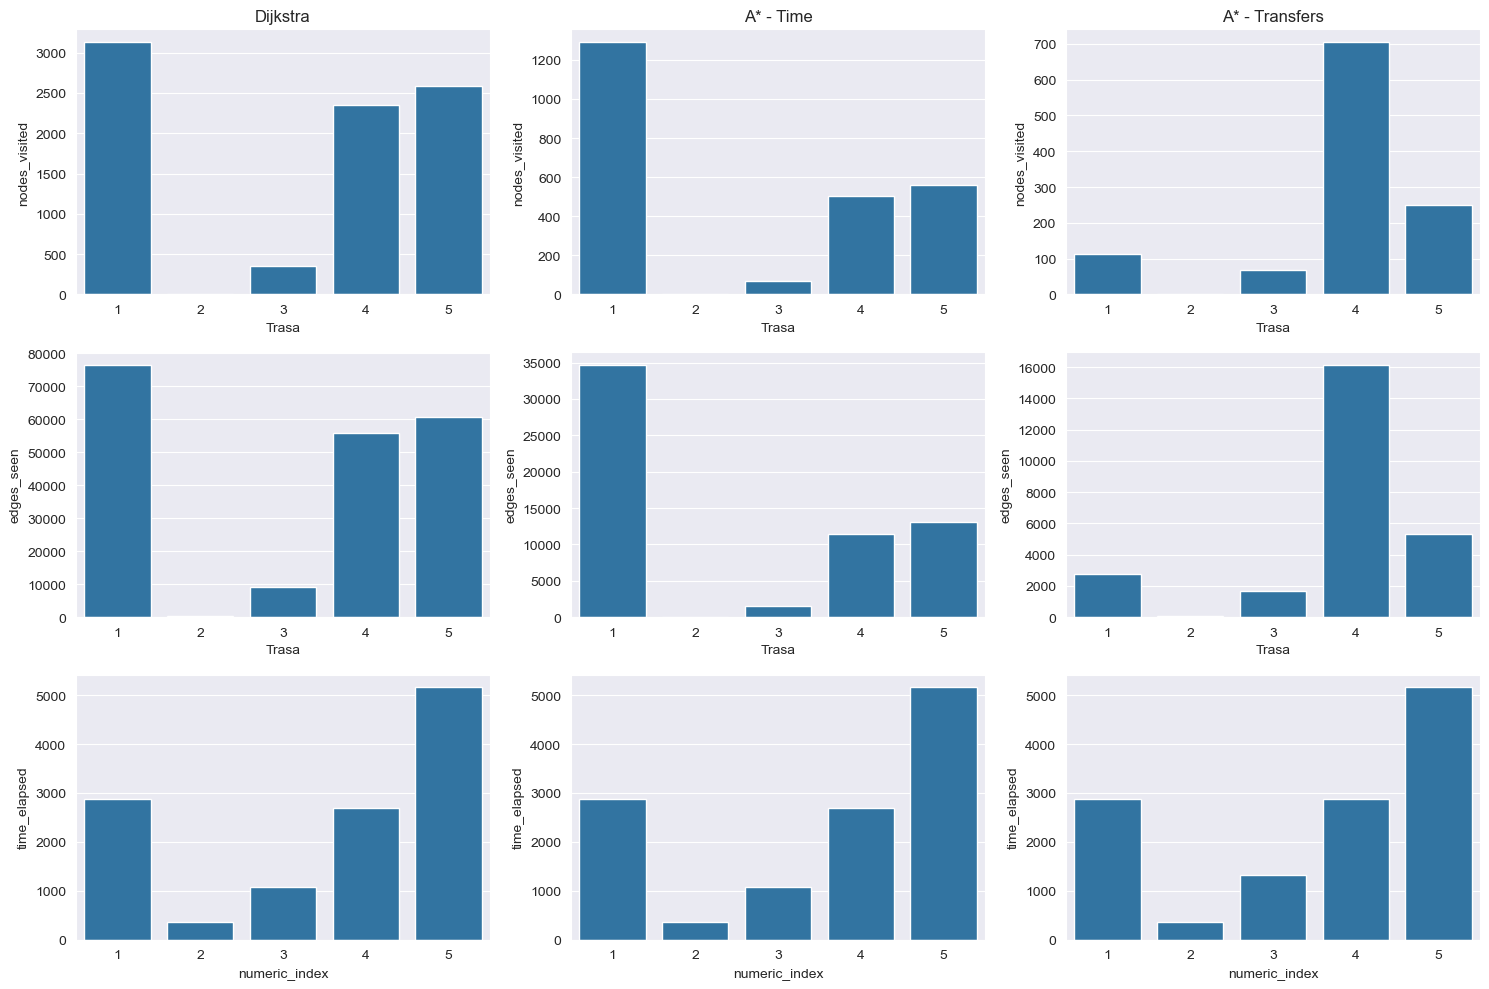

In [36]:
fig,ax = plt.subplots(3,3,figsize=(15,10))



for i,rdict in enumerate(dict_list):
    data_rows = []
    for (key1, key2, start_time_str), (nodes_visited, edges_seen, node_obj) in rdict.items():
    
        time_elapsed = node_obj.arrival_time - parse_time(start_time_str)
        data_rows.append({
            'Key1': key1,
            'Key2': key2, 
            'start_time_str': start_time_str,
            'nodes_visited': nodes_visited,
            'edges_seen': edges_seen,
            'time_elapsed': time_elapsed
        })
        
    # Convert to DataFrame
    df = pd.DataFrame(data_rows)
    df = df.reset_index(drop=True)
    df['numeric_index'] = df.index + 1  # Start from 1 instead of 0
    
    sns.barplot(x="numeric_index", y="nodes_visited", data=df, ax=ax[0,i])
    sns.barplot(x="numeric_index", y="edges_seen", data=df, ax=ax[1,i])
    sns.barplot(x="numeric_index", y="time_elapsed", data=df, ax=ax[2,i])
    

    
    ax[0,i].set_title(alg_names[i])
    ax[0,i].set_xlabel("Trasa")
    ax[1,i].set_xlabel("Trasa")
plt.tight_layout()

plt.show()
    
    

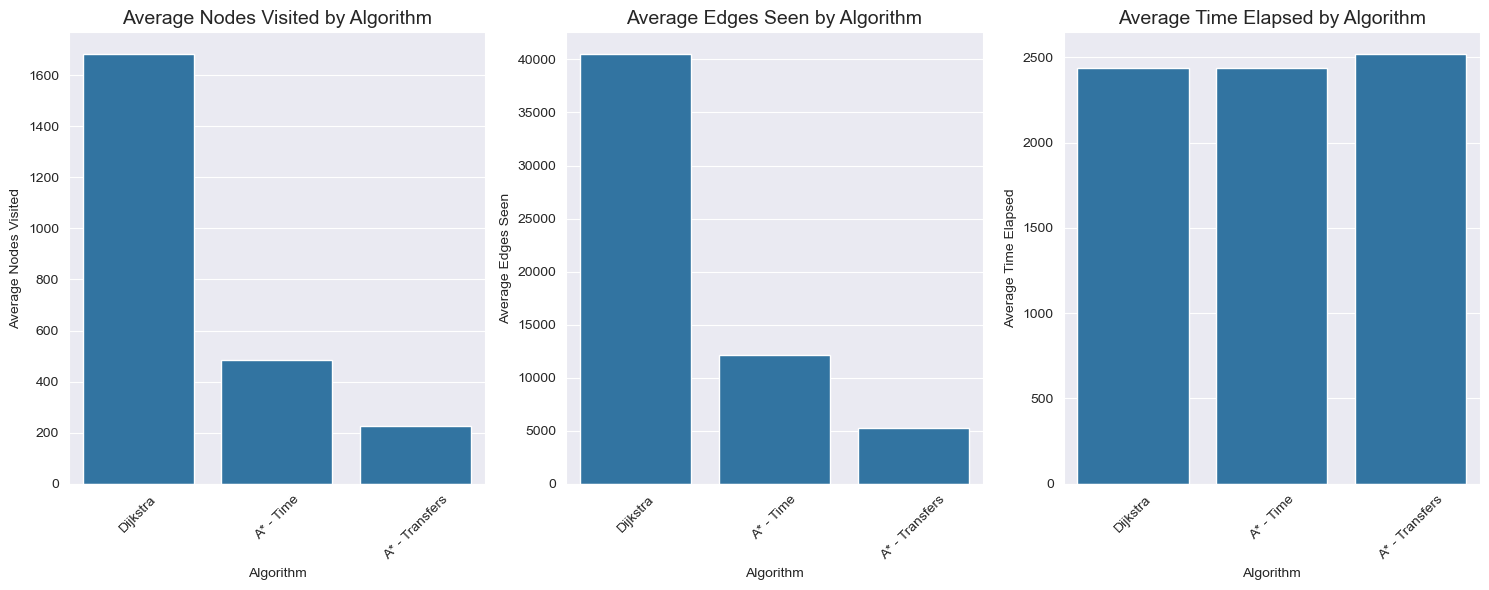

In [37]:
# Create a new figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 3, figsize=(15, 6))


avg_nodes = []
avg_edges = []
avg_time=[]

# Calculate average for each algorithm
for i, rdict in enumerate(dict_list):
    data_rows = []
    for (key1, key2, start_time_str), (nodes_visited, edges_seen, node_obj) in rdict.items():
        time_elapsed = node_obj.arrival_time - parse_time(start_time_str)
        data_rows.append({
            'nodes_visited': nodes_visited,
            'edges_seen': edges_seen,
            'time_elapsed': time_elapsed
        })
    
    # Convert to DataFrame and calculate averages
    df = pd.DataFrame(data_rows)
    avg_nodes.append(df['nodes_visited'].mean())
    avg_edges.append(df['edges_seen'].mean())
    avg_time.append(df['time_elapsed'].mean())

# Create new DataFrames for plotting the averages
avg_data = pd.DataFrame({
    'Algorithm': alg_names,
    'Avg Nodes Visited': avg_nodes,
    'Avg Edges Seen': avg_edges,
    'Avg Time Elapsed': avg_time
})

# Plot the first subplot - Average Nodes Visited
sns.barplot(x='Algorithm', y='Avg Nodes Visited', data=avg_data, ax=ax[0])
ax[0].set_title('Average Nodes Visited by Algorithm', fontsize=14)
ax[0].set_ylabel('Average Nodes Visited')
ax[0].tick_params(axis='x', rotation=45)

# Plot the second subplot - Average Edges Seen
sns.barplot(x='Algorithm', y='Avg Edges Seen', data=avg_data, ax=ax[1])
ax[1].set_title('Average Edges Seen by Algorithm', fontsize=14)
ax[1].set_ylabel('Average Edges Seen')
ax[1].tick_params(axis='x', rotation=45)

# Plot the third subplot - Average Time Elapsed
sns.barplot(x='Algorithm', y='Avg Time Elapsed', data=avg_data, ax=ax[2])
ax[2].set_title('Average Time Elapsed by Algorithm', fontsize=14)
ax[2].set_ylabel('Average Time Elapsed')
ax[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()
    
    

### WNIOSKI
 ###

1. Co ciekawe, algorytm Dijkstry jest zawsze szybszy od A*. Możliwe, że wynika to z faktu, że A* dodatkowo liczy heurystykę, co zwiększa czas obliczeń. Liczba odwiedzonych węzłów jest sporo większa (680 w A* do 3000 Dijkstra).
2. Wprowadzenie modyfikacji grafu jak i wyszukiwaniu sąsiadów pozwoliło na bardzo duże obniżenie czasu obliczeń. Wcześciej algorytm iterował po wszystkich możliwych, łapalnych kursach. Teraz, ogranicza się do unikalnych par (linia, kierunek).
3. Trasa wyznaczana w problemie komiwojażera skutecznie wybiera trasy i potrzebne przesiadki.(Lub skutecznie wykrywa brak potrzeby przesiadki)
4.